In [9]:
#RUN THE NIRS Event Conversion SCRIPT in the Beh notebook WHEN NEW SUBJECTS HAVE BEEN ADDED

#general dependencies (importing premade packages/libraries)
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress
from tqdm import tqdm

In [10]:
from platform import python_version
python_version()

'3.12.3'

In [11]:
import pycwt as wavelet
from pycwt.helpers import find

In [12]:
import io
from copy import copy
from collections import OrderedDict
import requests

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../../..')
from LCBDtools.src import argParser
from LCBDtools.src import Plots

In [15]:
# Some configuration variables
study_dir = "/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU"
participant_num_len = 4 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset
debug = True

# set block durations (original data has start and stop data points, those stop data points are eventually removed to replace with durations instead, they are easier to work with)
durations = {
    'Block 1': 120,
    'Block 2': 105,
    'Block 3': 120}

In [16]:
# set the channels for each ROI
ROIs = {
    'Left Frontal': ['S3_D2 hbo', 'S4_D2 hbo'],
    'Right Frontal': ['S5_D3 hbo', 'S6_D3 hbo'],
    'Left Temporal': ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo'],
    'Right Temporal': ['S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo']}

In [17]:
# make a list of all matching session paths (in this case for V0, assuming there should be more sessions?)
session_dirs = [d for d in glob(study_dir+"/*/*DB-DOS/*") \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [18]:
session_dirs

['/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1168/1168_DB-DOS/1168-C_fNIRS_DB-DOS',
 '/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1168/1168_DB-DOS/1168-P_fNIRS_DB-DOS',
 '/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1234/1234_DB-DOS/1234-C_fNIRS_DB-DOS',
 '/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1234/1234_DB-DOS/1234-P_fNIRS_DB-DOS',
 '/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1154/1154_DB-DOS/1154-C_fNIRS_DB-DOS',
 '/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1154/1154_DB-DOS/1154-P_fNIRS_DB-DOS',
 '/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1249/1249_DB-DOS/1249-C_fNIRS_DB-DOS',
 '/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1249/1249_DB-DOS/1249-P_fNIRS_DB-DOS',
 '/storage1/fs1/perlmansusan/Act

In [19]:
len(session_dirs)

246

In [20]:
len(session_dirs)/2

123.0

In [52]:
# make a list where all of the scans will get loaded into (for children and for parent)
scans = []
successful_load = []

# loop over all the session directories (dyads / DB-DOS folders)
for dyad_dir in list(set([os.path.split(ses)[0] for ses in session_dirs])):
    try:
        # get subject and visit from this path
        sub = os.path.basename(os.path.dirname(dyad_dir))
        if debug:
            print(sub)
        
        # determining whether sub is Child or Parent can be done by reading the config file in the .nirx directory        
        config_files = glob(os.path.join(dyad_dir, "*DB-DOS", "*config*")) # 

        # open the file and read the line with Subject= in it
        for config in config_files:
            with open(config, 'r') as f:
                line = f.readline()
                while "Subject=" not in line:
                    line = f.readline()
                line = line.strip()
                line = line.replace("Subject=", "")
                
                # if the line is 1 it's the child
                if line == "1":
                    sub1 = os.path.dirname(config) # child
                elif line == "2":
                    sub2 = os.path.dirname(config) # parent
        
        # make sure it has 'modern' .evt files
        evts = glob(sub1 + "/*.evt")
        if len(evts) != 2:
            print("There should be 2 evt files. Skipping:", os.path.basename(sub1))
            continue
        print("Subject 1: ", sub1)
#         #**load each in via hypyp loader (fixing config file so that even if child and parent numbers were flipped, they will now each be labelled as c or p in object)**
        fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
        fnirs_participant_1.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}c"
        
        fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
        fnirs_participant_2.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}p"
        
        scans.append((fnirs_participant_1, fnirs_participant_2))
        successful_load.append(sub)
    # If anything fails with loading subject, skip   
    except:
        print("skipping session:", dyad_dir)
        continue

1102
There should be 2 evt files. Skipping: 1102-C_fNIRS_DB-DOS
1234
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1234/1234_DB-DOS/1234-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1133
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1133/1133_DB-DOS/1133-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1151
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1151/1151_DB-DOS/1151-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1162
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1162/1162_DB-DOS/1162-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1249
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1249/1249_DB-DOS/1249-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: Omitted 16 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: Omitted 16 annotation(s) that were outside data range.
  fnirs_partic

1159
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1159/1159_DB-DOS/1159-C_fNIRS_DB-DOS
1191
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1191/1191_DB-DOS/1191-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1145
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1145/1145_DB-DOS/1145-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1190
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1190/1190_DB-DOS/1190-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1216
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1216/1216_DB-DOS/1216-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1184
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1184/1184_DB-DOS/1184-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1143
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1143/1143_DB-DOS/1143-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1237
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1237/1237_DB-DOS/1237-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: Omitted 16 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: Omitted 16 annotation(s) that were outside data range.
  fnirs_partic

1220
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1220/1220_DB-DOS/1220-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1214
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1214/1214_DB-DOS/1214-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1165
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1165/1165_DB-DOS/1165-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1229
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1229/1229_DB-DOS/1229-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1103
There should be 2 evt files. Skipping: 1103-C_fNIRS_DB-DOS
1138
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1138/1138_DB-DOS/1138-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1235
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1235/1235_DB-DOS/1235-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1251
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1251/1251_DB-DOS/1251-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1225
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1225/1225_DB-DOS/1225-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1125
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1125/1125_DB-DOS/1125-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1118
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1118/1118_DB-DOS/1118-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1182
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1182/1182_DB-DOS/1182-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1223
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1223/1223_DB-DOS/1223-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1127
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1127/1127_DB-DOS/1127-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1124
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1124/1124_DB-DOS/1124-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1245
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1245/1245_DB-DOS/1245-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1247
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1247/1247_DB-DOS/1247-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1155
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1155/1155_DB-DOS/1155-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1263
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1263/1263_DB-DOS/1263-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1180
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1180/1180_DB-DOS/1180-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1252
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1252/1252_DB-DOS/1252-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1243
There should be 2 evt files. Skipping: 1243-C_fNIRS_DB-DOS
1268
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1268/1268_DB-DOS/1268-C_fNIRS_DB-DOS
1119
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1119/1119_DB-DOS/1119-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1156
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1156/1156_DB-DOS/1156-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1142
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1142/1142_DB-DOS/1142-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  fnirs_particip

1207
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1207/1207_DB-DOS/1207-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1228
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1228/1228_DB-DOS/1228-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1193
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1193/1193_DB-DOS/1193-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1211
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1211/1211_DB-DOS/1211-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1236
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1236/1236_DB-DOS/1236-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1112
There should be 2 evt files. Skipping: 1112-C_fNIRS_DB-DOS
1174
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1174/1174_DB-DOS/1174-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1219
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1219/1219_DB-DOS/1219-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1179
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1179/1179_DB-DOS/1179-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1204
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1204/1204_DB-DOS/1204-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1134
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1134/1134_DB-DOS/1134-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1242
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1242/1242_DB-DOS/1242-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1195
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1195/1195_DB-DOS/1195-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1113
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1113/1113_DB-DOS/1113-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1130
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1130/1130_DB-DOS/1130-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1269
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1269/1269_DB-DOS/1269-C_fNIRS_DB-DOS
1226
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1226/1226_DB-DOS/1226-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1267
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1267/1267_DB-DOS/1267-C_fNIRS_DB-DOS
1213
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1213/1213_DB-DOS/1213-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1258
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1258/1258_DB-DOS/1258-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1122
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1122/1122_DB-DOS/1122-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1170
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1170/1170_DB-DOS/1170-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1115
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1115/1115_DB-DOS/1115-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1238
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1238/1238_DB-DOS/1238-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: Omitted 15 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: Omitted 15 annotation(s) that were outside data range.
  fnirs_partic

1149
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1149/1149_DB-DOS/1149-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1129
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1129/1129_DB-DOS/1129-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1139
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1139/1139_DB-DOS/1139-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1253
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1253/1253_DB-DOS/1253-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1178
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1178/1178_DB-DOS/1178-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1114
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1114/1114_DB-DOS/1114-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1265
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1265/1265_DB-DOS/1265-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1110
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1110/1110_DB-DOS/1110-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1254
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1254/1254_DB-DOS/1254-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1172
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1172/1172_DB-DOS/1172-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1240
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1240/1240_DB-DOS/1240-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1144
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1144/1144_DB-DOS/1144-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1121
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1121/1121_DB-DOS/1121-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1264
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1264/1264_DB-DOS/1264-C_fNIRS_DB-DOS
1188
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1188/1188_DB-DOS/1188-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1203
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1203/1203_DB-DOS/1203-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1209
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1209/1209_DB-DOS/1209-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: Omitted 5 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: Omitted 5 annotation(s) that were outside data range.
  fnirs_particip

1167
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1167/1167_DB-DOS/1167-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1148
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1148/1148_DB-DOS/1148-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1154
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1154/1154_DB-DOS/1154-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1255
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1255/1255_DB-DOS/1255-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1232
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1232/1232_DB-DOS/1232-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1250
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1250/1250_DB-DOS/1250-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1131
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1131/1131_DB-DOS/1131-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1194
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1194/1194_DB-DOS/1194-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1137
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1137/1137_DB-DOS/1137-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1160
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1160/1160_DB-DOS/1160-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1244
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1244/1244_DB-DOS/1244-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1221
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1221/1221_DB-DOS/1221-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1164
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1164/1164_DB-DOS/1164-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1175
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1175/1175_DB-DOS/1175-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1222
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1222/1222_DB-DOS/1222-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1200
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1200/1200_DB-DOS/1200-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1266
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1266/1266_DB-DOS/1266-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1176
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1176/1176_DB-DOS/1176-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1187
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1187/1187_DB-DOS/1187-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1116
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1116/1116_DB-DOS/1116-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1168
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1168/1168_DB-DOS/1168-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1270
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1270/1270_DB-DOS/1270-C_fNIRS_DB-DOS
1205
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1205/1205_DB-DOS/1205-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1141
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1141/1141_DB-DOS/1141-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1117
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1117/1117_DB-DOS/1117-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1256
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1256/1256_DB-DOS/1256-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1177
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1177/1177_DB-DOS/1177-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1104
There should be 2 evt files. Skipping: 1104-C_fNIRS_DB-DOS
1248
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1248/1248_DB-DOS/1248-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1231
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1231/1231_DB-DOS/1231-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child


1186
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1186/1186_DB-DOS/1186-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1147
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1147/1147_DB-DOS/1147-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1239
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1239/1239_DB-DOS/1239-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  fnirs_particip

1202
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1202/1202_DB-DOS/1202-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1109
There should be 2 evt files. Skipping: 1109-C_fNIRS_DB-DOS
1126
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1126/1126_DB-DOS/1126-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1189
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1189/1189_DB-DOS/1189-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1185
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1185/1185_DB-DOS/1185-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1146
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1146/1146_DB-DOS/1146-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1246
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1246/1246_DB-DOS/1246-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1173
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1173/1173_DB-DOS/1173-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


1227
Subject 1:  /storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1227/1227_DB-DOS/1227-C_fNIRS_DB-DOS


/tmp/684302.tmpdir/ipykernel_382/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/684302.tmpdir/ipykernel_382/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


In [53]:
len(scans)

117

In [ ]:
#raw NIRS data for child and parent now loaded into "scans" object
scans

In [54]:
#Listing subjects that were missing 2 EVT files
failed_load = []
soi = os.listdir('/storage1/fs1/perlmansusan/Active/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU')
for subject in soi:
    if subject not in successful_load:
        failed_load.append(subject)
        
failed_load

['1112', '1243', '1109', '1102', '1103', '1104']

In [55]:
X = scans[0][0].get_data()

In [56]:
scans[0][0].get_data()

array([[0.272801 , 0.2779718, 0.2754435, ..., 0.5047884, 0.5118747,
        0.5111634],
       [0.2814404, 0.2874472, 0.2857209, ..., 0.4677824, 0.4818496,
        0.4786235],
       [0.1185223, 0.1197051, 0.1185407, ..., 0.2352948, 0.2374441,
        0.2343254],
       ...,
       [0.1885247, 0.189146 , 0.1865552, ..., 0.2372174, 0.2386488,
        0.2314181],
       [0.0995186, 0.0990854, 0.0961964, ..., 0.157442 , 0.1571644,
        0.1503837],
       [0.1257442, 0.1256986, 0.1214659, ..., 0.1949724, 0.1952066,
        0.1849272]])

In [57]:
scans[0][0].get_data().shape

(20, 16099)

In [58]:
t = scans[0][0].times

In [59]:
scans[26][0].times

array([0.000000e+00, 1.280000e-01, 2.560000e-01, ..., 1.903104e+03,
       1.903232e+03, 1.903360e+03])

In [60]:
scans[0][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

In [61]:
plt.plot(
    t,
    X[10]
)

In [62]:
#can use to check the subject info for each member of dyad in the scans object. First number selects dyad pair, 2nd number: 0 = child, 1 = parent
scans[115][0].info['subject_info']

<subject_info | his_id: 1173c, first_name: 1173-Child, sex: 0 (FIFFV_SUBJ_SEX_UNKNOWN), birthday: 2022-10-07>

In [63]:
#Checking annotation before running script to remove the stop annotations
scans[0][0].annotations

<Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>

In [64]:
#if annotations don't match across subjects, need to check the evt files for consistency, run a event conversion script for the data
for scan in scans:
    print(scan[0].info['subject_info']['his_id'],scan[0].annotations)


1234c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1133c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1151c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1162c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1249c <Annotations | 8 segments: 1.0 (4), 128.0 (4)>
1159c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1191c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1145c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1190c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1216c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1184c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1143c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1237c <Annotations | 8 segments: 1.0 (4), 128.0 (4)>
1220c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1214c <Annotations

In [65]:
# rename events and set durations for block 1 and 2

# if we can't load in the annotations right, we'll remove them from our list of scans
bads = []

for i, dscan in enumerate(scans):
    
    try:
        for scan in dscan:

            # rename the binary annotations with actual names
            scan.annotations.rename({
                '1.0': 'Block 1',
                '2.0': 'Block 2',
                '4.0': 'Block 3'})

            # remove any stop annotations
            scan.annotations.delete(scan.annotations.description == '128.0')

            # set the durations based off the durations dictionary
            scan.annotations.set_durations(durations, verbose=True)
    
    except:
        bads.append(i)
        
for i in sorted(bads, reverse=True):
    del scans[i]

In [66]:
scans[0][0].annotations

<Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>

In [67]:
#Check to confirm that annotations are now consistent across subjects
for scan in scans:
    print(scan[0].info['subject_info']['his_id'],scan[0].annotations)

1234c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1133c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1151c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1162c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1159c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1191c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1145c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1190c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1216c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1184c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1143c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1220c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1214c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1165c <Annotations | 12 segments: Block 1 (4), Bloc

In [68]:
#This will let you know how many subjects could have their psychopy annotatations standardized
len(scans)

109

In [69]:
scans

[(<RawNIRX | 1234-C_fNIRS_DB-DOS, 20 x 16099 (2060.7 s), ~25 KiB, data not loaded>,
  <RawNIRX | 1234-P_fNIRS_DB-DOS, 20 x 16099 (2060.7 s), ~25 KiB, data not loaded>),
 (<RawNIRX | 1133-C_fNIRS_DB-DOS, 20 x 15438 (1976.1 s), ~25 KiB, data not loaded>,
  <RawNIRX | 1133-P_fNIRS_DB-DOS, 20 x 15438 (1976.1 s), ~25 KiB, data not loaded>),
 (<RawNIRX | 1151-C_fNIRS_DB-DOS, 20 x 16021 (2050.7 s), ~25 KiB, data not loaded>,
  <RawNIRX | 1151-P_fNIRS_DB-DOS, 20 x 16021 (2050.7 s), ~25 KiB, data not loaded>),
 (<RawNIRX | 1162-C_fNIRS_DB-DOS, 20 x 15255 (1952.6 s), ~25 KiB, data not loaded>,
  <RawNIRX | 1162-P_fNIRS_DB-DOS, 20 x 15255 (1952.6 s), ~25 KiB, data not loaded>),
 (<RawNIRX | 1159-C_fNIRS_DB-DOS, 20 x 14852 (1901.1 s), ~25 KiB, data not loaded>,
  <RawNIRX | 1159-P_fNIRS_DB-DOS, 20 x 14852 (1901.1 s), ~25 KiB, data not loaded>),
 (<RawNIRX | 1191-C_fNIRS_DB-DOS, 20 x 15048 (1926.1 s), ~25 KiB, data not loaded>,
  <RawNIRX | 1191-P_fNIRS_DB-DOS, 20 x 15048 (1926.1 s), ~25 KiB, data 

In [70]:
scans[1][0].annotations.to_data_frame()

,onset,duration,description
0,2022-03-31 12:56:47.969,120.0,Block 1
1,2022-03-31 12:59:01.729,120.0,Block 1
2,2022-03-31 13:01:15.489,120.0,Block 1
3,2022-03-31 13:03:29.249,120.0,Block 1
4,2022-03-31 13:09:55.681,105.0,Block 2
5,2022-03-31 13:11:54.209,105.0,Block 2
6,2022-03-31 13:13:52.737,105.0,Block 2
7,2022-03-31 13:15:51.393,105.0,Block 2
8,2022-03-31 13:20:26.849,120.0,Block 3
9,2022-03-31 13:22:40.609,120.0,Block 3


In [71]:
from typing import Union

# function to do Continuous Wavelet Transform on a single signal
#Sig1: raw MNE converted signal or Epoch; plot = set whether you want to plot the wavelet (True or False); chs: produce a wavelet for a specific channel
def mne_wavelet_transform(sig1: [mne.io.Raw, mne.Epochs], plot: bool = True,
                      chs: Union[str] = None):
    """
    Perform a continuous wavelet transform based off data in mne Raw object
    """
    
    #Fourier Transform "transforms" data from time to frequency domain (certain number of oscillations per second)
    #The the final wavelet transform is an intermediate between time and frequency domain, it just needs to be transformed to frquency first
    # set time ##t0 = start time and dt = distance in time from t0. N is length
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
    #t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters ## Clayton Add reference for parameters? (By default uses a Morlet convolution function to align detected signal with
    # with this base function) 
    #Video on Morlet wavelets
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    #reshaping of signal
    for ch in chs:
        dat = np.squeeze(sig1.get_data(picks=[ch])) * 1e5
        
        # detrend and normalize the input data by its standard deviation (to remove drift effects)
        p = np.polyfit(t - t0, dat, 1)
        dat_notrend = dat - np.polyval(p, t - t0)
        std = dat_notrend.std() # standard deviation
        var = std ** 2 # variance
        dat_norm = dat_notrend / std # normalized dataset
        
        alpha, _, _ = wavelet.ar1(dat) # lag-1 autocorrelation for red noise
        
        #This is the actual function where dat_norm, dt etc. are entered to produce the wavelet tranformed matrix, weighted scales for each matrix, list of frequencies
        # coming from each matrix, the cone of influence (gives a prospective range in which signal should closely convolve with Morlet),
        #fast fourier transform? (fft)
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            dat_norm, dt, dj, s0, J, mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    
        # plotting the fourier tranform
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        power /= scales[:, None] # optional according to Liu et al. (2007)
        
        # power significance test (the degree of convergence of the signal and the Morlet function? Also compare frequencies in one epoch vs the other?)
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, alpha,
            significance_level=0.95, 
            wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95
        
        # calculate global wavelet spectrum and determine its significance level
        glbl_power = power.mean(axis=1)
        dof = N - scales # correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        # calculate scale average and its significance level
        sel = find((period >= 10) & (period < 50))
        Cdelta = mother.cdelta
        scale_avg = (scales * np.ones((N, 1))).transpose()
        scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
        scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
        scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                    significance_level=0.95,
                                                    dof=[scales[sel[0]],
                                                        scales[sel[-1]]],
                                                    wavelet=mother)
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} Channel {ch} Continuous Wavelet Transform"
            label = ""
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the original time series
            ax = plt.axes([0.1, 0.75, 0.65, 0.2])
            ax.plot(t, dat, 'k', linewidth=1.5)
            ax.set_title('a) {}'.format(title))
            ax.set_ylabel(r'{} [{}]'.format(label, units))
            
            # second sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
            levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            conmap = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), 
                        extend='both', cmap=plt.cm.jet)
#             plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
            bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                                  extent=extent)
            bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
            bx.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            bx.set_yticks(np.log2(Yticks))
            bx.set_yticklabels(1/Yticks)
            
            # third sub-plot, the global wavelet and Fourier power spectra and theoretical
            # noise spectra. Note that period scale is logarithmic
            cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
            cx.plot(glbl_signif, np.log2(period), 'k--')
            cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
            cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
                    linewidth=1.)
            cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
            cx.set_title('c) Global Wavelet Spectrum')
            cx.set_xlabel(r'Power [({})^2]'.format(units))
            cx.set_xlim([0, glbl_power.max() + var])
            cx.set_ylim(np.log2([period.min(), period.max()]))
            cx.set_yticks(np.log2(Yticks))
            cx.set_yticklabels(1/Yticks)
            plt.setp(cx.get_yticklabels(), visible=False)
            
            # Fourth sub-plot, the scale averaged wavelet spectrum.
            dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
            dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
            dx.plot(t, scale_avg, 'k-', linewidth=1.5)
            dx.set_title('d) {}--{} second scale-averaged power'.format(2, 8))
            dx.set_xlabel('Time (seconds)')
            dx.set_ylabel(r'Average variance [{}]'.format(units))
            ax.set_xlim([t.min(), t.max()])

            plt.show()
    
    return wave, scales, freqs, coi, fft, fftfreqs


# function to do wavelet coherence transform on 2 signals
def mne_wavelet_coherence_transform(sig1: [mne.io.Raw, mne.Epochs],
        sig2: [mne.io.Raw, mne.Epochs],
        plot: bool = True, fig_fname: str = None,
        chs: Union[str] = None):
    
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    for ch in chs:
        dat1 = np.squeeze(sig1.get_data(picks=[ch]))
        dat2 = np.squeeze(sig2.get_data(picks=[ch]))
        
        if np.isnan(dat1).any():
            print("Dat 1 contains NaN values")
            raise ValueError
            
        if np.isnan(dat2).any():
            print("Dat 2 contains NaN values")
            raise ValueError
        
        # detrend and normalize the input data by its standard deviation
        p1 = np.polyfit(t - t0, dat1, 1)
        dat_notrend1 = dat1 - np.polyval(p1, t - t0)
        std1 = dat_notrend1.std() # standard deviation
        var1 = std1 ** 2 # variance
        dat_norm1 = dat_notrend1 / std1 # normalized dataset
        
        # detrend and normalize the input data by its standard deviation
        p2 = np.polyfit(t - t0, dat2, 1)
        dat_notrend2 = dat2 - np.polyval(p2, t - t0)
        std2 = dat_notrend2.std() # standard deviation
        var2 = std2 ** 2 # variance
        dat_norm2 = dat_notrend2 / std2 # normalized dataset
        
        WCT, aWCT, coi, freqs, sig95 = wavelet.wct(
            dat_norm1, dat_norm2,
            dt, dj=dj, s0=s0, J=J, sig=False,
            significance_level=0.95, wavelet='morlet',
            normalize=True)
        
        period = 1 / freqs
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} / {sig2.info['subject_info']['his_id']} Channel {ch} Wavelet Coherence Transform"
            label = f"{sig1.info['subject_info']['his_id']} {sig2.info['subject_info']['his_id']} {ch}"
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            ax = plt.axes([0.1, 0.37, 0.65, 0.28])
#             levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            levels = list(np.arange(0.1, 1, step=0.1))
            conmap = ax.contourf(t, np.log2(period), WCT, levels, 
                        extend='both', cmap=plt.cm.jet)
            plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
#             ax.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#                                   extent=extent)
            ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            ax.set_title('b) {} Wavelet Coherence Spectrum ({})'.format(label, mother.name))
            ax.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            ax.set_yticks(np.log2(Yticks))
            ax.set_yticklabels(1/Yticks)
            ax.set_xlim([t.min(), t.max()])
            ax.set_ylim(np.log2([period.min(), period.max()]))
            
            if fig_fname is None:
                plt.show()
            else:
                plt.savefig(fig_fname)
            
    return WCT, aWCT, coi, freqs, sig95 

In [72]:
#will be converted to HbO and HbR channels later in the script
scans[1][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

In [73]:
for ind, scan in enumerate(scans):
    print(ind, scan)

0 (<RawNIRX | 1234-C_fNIRS_DB-DOS, 20 x 16099 (2060.7 s), ~25 KiB, data not loaded>, <RawNIRX | 1234-P_fNIRS_DB-DOS, 20 x 16099 (2060.7 s), ~25 KiB, data not loaded>)
1 (<RawNIRX | 1133-C_fNIRS_DB-DOS, 20 x 15438 (1976.1 s), ~25 KiB, data not loaded>, <RawNIRX | 1133-P_fNIRS_DB-DOS, 20 x 15438 (1976.1 s), ~25 KiB, data not loaded>)
2 (<RawNIRX | 1151-C_fNIRS_DB-DOS, 20 x 16021 (2050.7 s), ~25 KiB, data not loaded>, <RawNIRX | 1151-P_fNIRS_DB-DOS, 20 x 16021 (2050.7 s), ~25 KiB, data not loaded>)
3 (<RawNIRX | 1162-C_fNIRS_DB-DOS, 20 x 15255 (1952.6 s), ~25 KiB, data not loaded>, <RawNIRX | 1162-P_fNIRS_DB-DOS, 20 x 15255 (1952.6 s), ~25 KiB, data not loaded>)
4 (<RawNIRX | 1159-C_fNIRS_DB-DOS, 20 x 14852 (1901.1 s), ~25 KiB, data not loaded>, <RawNIRX | 1159-P_fNIRS_DB-DOS, 20 x 14852 (1901.1 s), ~25 KiB, data not loaded>)
5 (<RawNIRX | 1191-C_fNIRS_DB-DOS, 20 x 15048 (1926.1 s), ~25 KiB, data not loaded>, <RawNIRX | 1191-P_fNIRS_DB-DOS, 20 x 15048 (1926.1 s), ~25 KiB, data not loaded>

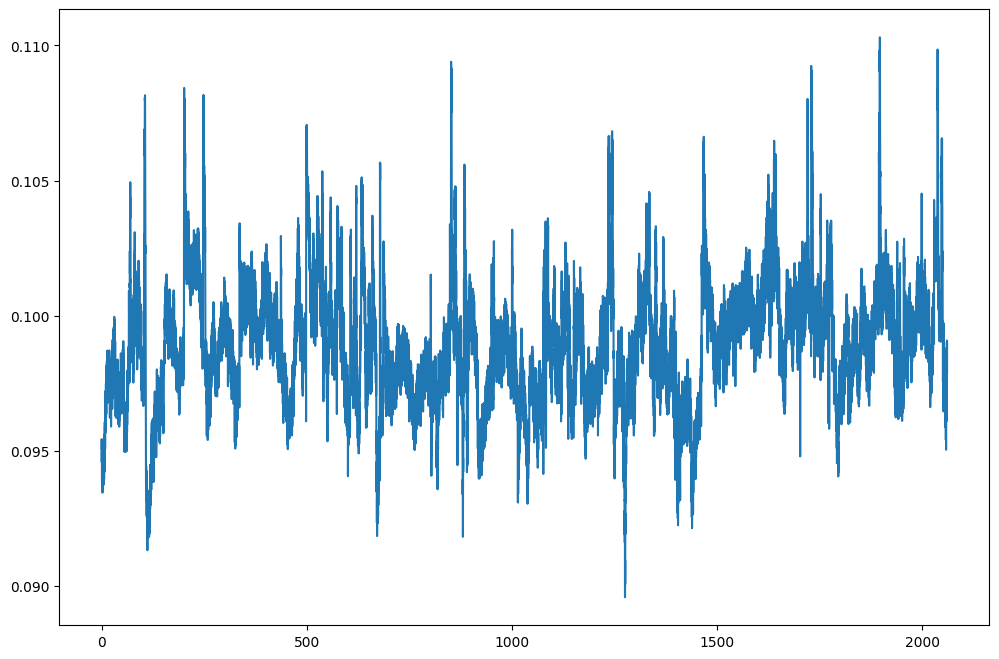

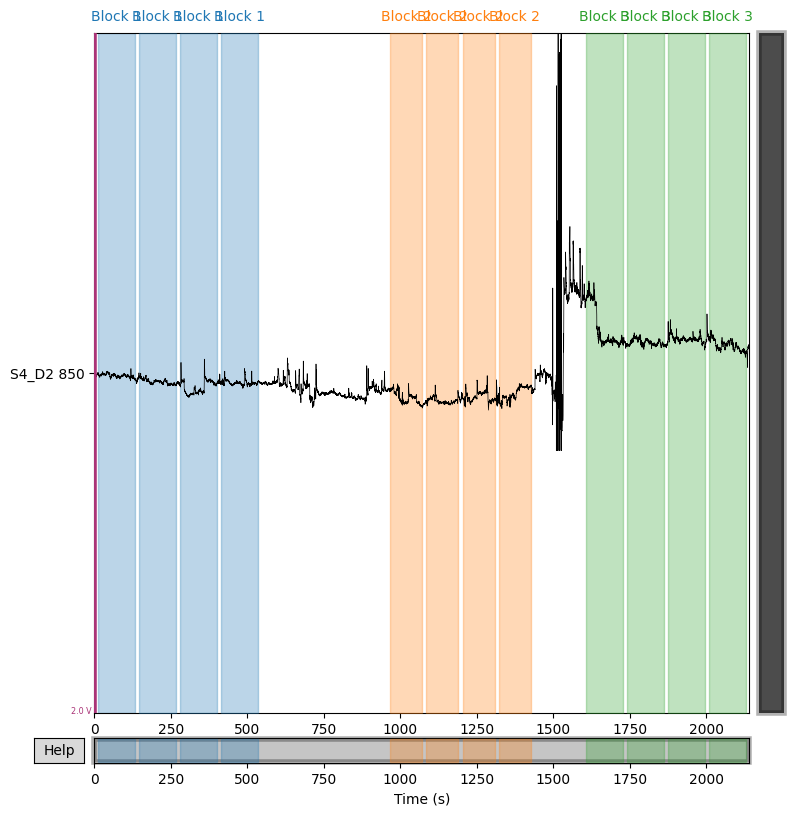

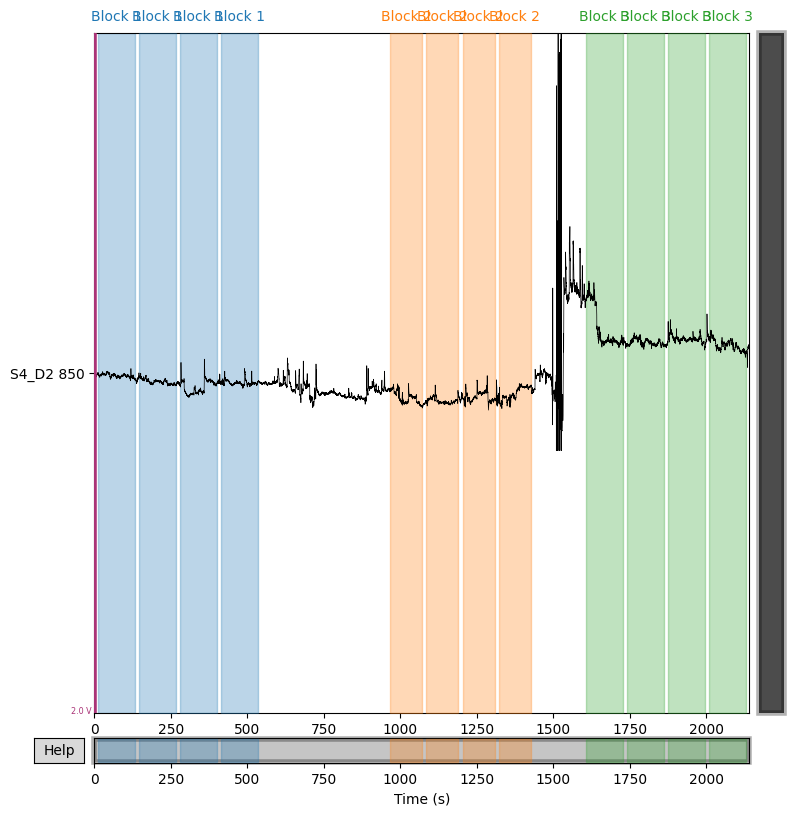

In [74]:
# example Block plot for 3000 seconds
#from this point forward, the first number in brackets following scans denotes subject number (select from 0-115), the 2nd number in brackets denotes whether you want to illustrate child (0) or parent (1) data
scans[20][0].copy().pick(['S4_D2 850']).plot(duration=3000, scalings=1)

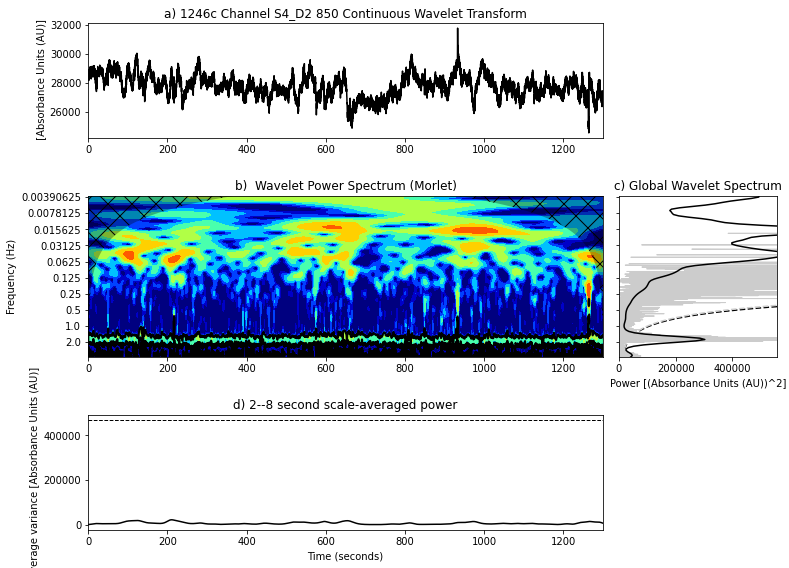

In [75]:
#Concise description of wavelet transform, inputs and outputs that were coded in the function above
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    #scans is object we built above that contains raw NIRS data from children and parent, to reiterate what was stated above, first index number in brackets
    #is the dyadic pair (can switch to any number of dyadic pairs in data, 2nd index is where you select child (0) or parent (1)
    scans[106][0].copy().crop(tmax=1300),
    #to plot the data, would say False if you want no plot
    plot=True,
    #select the channel(s) you want to visualize data from
    chs=['S4_D2 850'])

In [ ]:
#Concise description of wavelet transform, inputs and outputs that were coded in the function above (clean)
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[80][0].copy().crop(tmax=1000),
    plot=True,
    chs=['S4_D2 850'])

In [ ]:
# example plot for 2200 seconds
scans[50][1].copy().pick(['S2_D2 850']).plot(duration=2200, scalings=1)

In [ ]:
# example wavelet transform for 1800 seconds
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[3][1].copy().crop(tmax=1500),
    plot=True,
    chs=['S3_D2 850']
)

In [ ]:
# example coherence transform from a real dyad with 400 seconds (approach 1)
# 0 = child and 1 = parent for the 2nd index point of the scan object
#synchrony value goes from 0 to 1, 1 to max syncrhony
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[25][0].copy().crop(tmax=400),
    scans[25][1].copy().crop(tmax=400),
    plot=True,
    chs=['S1_D1 850'])

In [ ]:
# example coherence transformo from a real dyad with 400 seconds (approach 2)
# 0 = child and 1 = parent for the 2nd index point of the scan object
#synchrony value goes from 0 to 1, 1 to max syncrhony
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[4][0].copy().pick(['S3_D2 850']).crop(tmax=400),
    scans[4][1].copy().pick(['S3_D2 850']).crop(tmax=400),
    plot=True)

# Preprocessing Step

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair (motion correction)
- Beer Lambert Law to Convert to Haemoglobin (c concentration)
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [81]:
#Here the signals collected from the various channels are converted to relaative hemoglobin concentration instead of a frequency waveform,
#which is what we were working with above before preprocessing

# make a list where the preprocessed scans will go
pps = []

# for each dyad scan in scans
for dscan in scans:

    ppdscan = [] # make a list for the preprocessed dyad's scans
    
    # individually preprocess each subject in dyad
    for scan in dscan:
        print(scan)
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)

        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
        
        # linear detrend, par example
#         raw.data[:] = scipy.signal.detrend(raw.get_data(), axis=-1, fit='linear')

        if len(raw_od.info['bads']) > 0:
            print("Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])
        
        try:
            # temporal derivative distribution repair (motion attempt)
            tddr_od = mne.preprocessing.nirs.tddr(raw_od)
    #         print("tddr")
    #         tddr_od.plot(
    #             n_channels=len(tddr_od.ch_names),
    #             scalings=0.1,
    #             duration=100,
    #             show_scrollbars=False)
        
            # savgol filter (linear polynomial smoothing)
    #         sav_od = raw_od.savgol_filter(0.5)
    #         print("savgol filtering")
    #         sav_od.plot(
    #             n_channels=len(sav_od.ch_names),
    #             scalings=0.1,
    #             duration=100,
    #             show_scrollbars=False)

            bp_od = tddr_od.filter(0.01, 0.5)
    #         print("bandpass")
    #         bp_od.plot(
    #             n_channels=len(bp_od.ch_names),
    #             duration=100,
    #             scalings=0.1,
    #             show_scrollbars=False)

            # haemoglobin conversion using Beer Lambert Law (this will change channel names from frequency to hemo or deoxy hemo labelling)
            haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
    #         print("haemo")
    #         haemo.plot(
    #             n_channels=len(haemo.ch_names),
    #             duration=100,
    #             scalings=0.0001,
    #             show_scrollbars=False)

    #         print("PSD")
    #         haemo_lp.plot_psd(average=True)

            ppdscan.append(haemo)
        except:
            print(f"Failed! {scan}")
        
    pps.append(ppdscan)

<RawNIRX | 1234-C_fNIRS_DB-DOS, 20 x 16099 (2060.7 s), ~25 KiB, data not loaded>
Reading 0 ... 16098  =      0.000 ...  2060.544 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1234-P_fNIRS_DB-DOS, 20 x 16099 (2060.7 s), ~25 KiB, data not loaded>
Reading 0 ... 16098  =      0.000 ...  2060.544 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1234p : ['S1_D1 760', 'S1_D1 850', 'S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1133-C_fNIRS_DB-DOS, 20 x 15438 (1976.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15437  =      0.000 ...  1975.936 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1133c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1133-P_fNIRS_DB-DOS, 20 x 15438 (1976.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15437  =      0.000 ...  1975.936 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1151-C_fNIRS_DB-DOS, 20 x 16021 (2050.7 s), ~25 KiB, data not loaded>
Reading 0 ... 16020  =      0.000 ...  2050.560 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1151c : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1151-P_fNIRS_DB-DOS, 20 x 16021 (2050.7 s), ~25 KiB, data not loaded>
Reading 0 ... 16020  =      0.000 ...  2050.560 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1162-C_fNIRS_DB-DOS, 20 x 15255 (1952.6 s), ~25 KiB, data not loaded>
Reading 0 ... 15254  =      0.000 ...  1952.512 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1162c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1162-P_fNIRS_DB-DOS, 20 x 15255 (1952.6 s), ~25 KiB, data not loaded>
Reading 0 ... 15254  =      0.000 ...  1952.512 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1162p : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1159-C_fNIRS_DB-DOS, 20 x 14852 (1901.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14851  =      0.000 ...  1900.928 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1159-P_fNIRS_DB-DOS, 20 x 14852 (1901.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14851  =      0.000 ...  1900.928 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1159p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1191-C_fNIRS_DB-DOS, 20 x 15048 (1926.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15047  =      0.000 ...  1926.016 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1191c : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850', 'S6_D3 760', 'S6_D3 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1191-P_fNIRS_DB-DOS, 20 x 15048 (1926.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15047  =      0.000 ...  1926.016 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1191p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850', 'S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

Failed! <RawNIRX | 1191-P_fNIRS_DB-DOS, 20 x 15048 (1926.1 s), ~25 KiB, data not loaded>
<RawNIRX | 1145-C_fNIRS_DB-DOS, 20 x 14739 (1886.6 s)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1145-P_fNIRS_DB-DOS, 20 x 14739 (1886.6 s), ~25 KiB, data not loaded>
Reading 0 ... 14738  =      0.000 ...  1886.464 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1190-C_fNIRS_DB-DOS, 20 x 15420 (1973.8 s), ~25 KiB, data not loaded>
Reading 0 ... 15419  =      0.000 ...  1973.632 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1190-P_fNIRS_DB-DOS, 20 x 15420 (1973.8 s), ~25 KiB, data not loaded>
Reading 0 ... 15419  =      0.000 ...  1973.632 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1216-C_fNIRS_DB-DOS, 20 x 16163 (2068.9 s), ~25 KiB, data not loaded>
Reading 0 ... 16162  =      0.000 ...  2068.736 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1216-P_fNIRS_DB-DOS, 20 x 16163 (2068.9 s), ~25 KiB, data not loaded>
Reading 0 ... 16162  =      0.000 ...  2068.736 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1216p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1184-C_fNIRS_DB-DOS, 20 x 15613 (1998.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15612  =      0.000 ...  1998.336 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1184-P_fNIRS_DB-DOS, 20 x 15613 (1998.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15612  =      0.000 ...  1998.336 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1143-C_fNIRS_DB-DOS, 20 x 14845 (1900.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14844  =      0.000 ...  1900.032 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1143-P_fNIRS_DB-DOS, 20 x 14845 (1900.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14844  =      0.000 ...  1900.032 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1220-C_fNIRS_DB-DOS, 20 x 15753 (2016.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15752  =      0.000 ...  2016.256 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1220-P_fNIRS_DB-DOS, 20 x 15753 (2016.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15752  =      0.000 ...  2016.256 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1214-C_fNIRS_DB-DOS, 20 x 15388 (1969.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15387  =      0.000 ...  1969.536 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1214-P_fNIRS_DB-DOS, 20 x 15388 (1969.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15387  =      0.000 ...  1969.536 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1165-C_fNIRS_DB-DOS, 20 x 16547 (2118.0 s), ~25 KiB, data not loaded>
Reading 0 ... 16546  =      0.000 ...  2117.888 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1165-P_fNIRS_DB-DOS, 20 x 16547 (2118.0 s), ~25 KiB, data not loaded>
Reading 0 ... 16546  =      0.000 ...  2117.888 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1229-C_fNIRS_DB-DOS, 20 x 15397 (1970.8 s), ~25 KiB, data not loaded>
Reading 0 ... 15396  =      0.000 ...  1970.688 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1229-P_fNIRS_DB-DOS, 20 x 15397 (1970.8 s), ~25 KiB, data not loaded>
Reading 0 ... 15396  =      0.000 ...  1970.688 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1138-C_fNIRS_DB-DOS, 20 x 14155 (1811.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14154  =      0.000 ...  1811.712 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1138-P_fNIRS_DB-DOS, 20 x 14155 (1811.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14154  =      0.000 ...  1811.712 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1235-C_fNIRS_DB-DOS, 20 x 15133 (1937.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15132  =      0.000 ...  1936.896 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1235-P_fNIRS_DB-DOS, 20 x 15133 (1937.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15132  =      0.000 ...  1936.896 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1251-C_fNIRS_DB-DOS, 20 x 15435 (1975.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15434  =      0.000 ...  1975.552 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1251-P_fNIRS_DB-DOS, 20 x 15435 (1975.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15434  =      0.000 ...  1975.552 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1251p : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1225-C_fNIRS_DB-DOS, 20 x 15432 (1975.3 s), ~25 KiB, data not loaded>
Reading 0 ... 15431  =      0.000 ...  1975.168 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1225-P_fNIRS_DB-DOS, 20 x 15432 (1975.3 s), ~25 KiB, data not loaded>
Reading 0 ... 15431  =      0.000 ...  1975.168 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1125-C_fNIRS_DB-DOS, 20 x 14358 (1837.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14357  =      0.000 ...  1837.696 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1125-P_fNIRS_DB-DOS, 20 x 14358 (1837.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14357  =      0.000 ...  1837.696 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1182-C_fNIRS_DB-DOS, 20 x 16729 (2141.3 s), ~25 KiB, data not loaded>
Reading 0 ... 16728  =      0.000 ...  2141.184 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1182-P_fNIRS_DB-DOS, 20 x 16729 (2141.3 s), ~25 KiB, data not loaded>
Reading 0 ... 16728  =      0.000 ...  2141.184 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1182p : ['S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1223-C_fNIRS_DB-DOS, 20 x 15081 (1930.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15080  =      0.000 ...  1930.240 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1223-P_fNIRS_DB-DOS, 20 x 15081 (1930.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15080  =      0.000 ...  1930.240 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1127-C_fNIRS_DB-DOS, 20 x 14347 (1836.4 s), ~25 KiB, data not loaded>
Reading 0 ... 14346  =      0.000 ...  1836.288 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1127c : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1127-P_fNIRS_DB-DOS, 20 x 14347 (1836.4 s), ~25 KiB, data not loaded>
Reading 0 ... 14346  =      0.000 ...  1836.288 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1124-C_fNIRS_DB-DOS, 20 x 14871 (1903.5 s), ~25 KiB, data not loaded>
Reading 0 ... 14870  =      0.000 ...  1903.360 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1124c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1124-P_fNIRS_DB-DOS, 20 x 14871 (1903.5 s), ~25 KiB, data not loaded>
Reading 0 ... 14870  =      0.000 ...  1903.360 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1245-C_fNIRS_DB-DOS, 20 x 15225 (1948.8 s), ~25 KiB, data not loaded>
Reading 0 ... 15224  =      0.000 ...  1948.672 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1245-P_fNIRS_DB-DOS, 20 x 15225 (1948.8 s), ~25 KiB, data not loaded>
Reading 0 ... 15224  =      0.000 ...  1948.672 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1247-C_fNIRS_DB-DOS, 20 x 14630 (1872.6 s), ~25 KiB, data not loaded>
Reading 0 ... 14629  =      0.000 ...  1872.512 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1247-P_fNIRS_DB-DOS, 20 x 14630 (1872.6 s), ~25 KiB, data not loaded>
Reading 0 ... 14629  =      0.000 ...  1872.512 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1155-C_fNIRS_DB-DOS, 20 x 14575 (1865.6 s), ~25 KiB, data not loaded>
Reading 0 ... 14574  =      0.000 ...  1865.472 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1155-P_fNIRS_DB-DOS, 20 x 14575 (1865.6 s), ~25 KiB, data not loaded>
Reading 0 ... 14574  =      0.000 ...  1865.472 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1263-C_fNIRS_DB-DOS, 20 x 15891 (2034.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15890  =      0.000 ...  2033.920 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1263-P_fNIRS_DB-DOS, 20 x 15891 (2034.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15890  =      0.000 ...  2033.920 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1180-C_fNIRS_DB-DOS, 20 x 14797 (1894.0 s), ~25 KiB, data not loaded>
Reading 0 ... 14796  =      0.000 ...  1893.888 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1180c : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1180-P_fNIRS_DB-DOS, 20 x 14797 (1894.0 s), ~25 KiB, data not loaded>
Reading 0 ... 14796  =      0.000 ...  1893.888 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1252-C_fNIRS_DB-DOS, 20 x 15993 (2047.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15992  =      0.000 ...  2046.976 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1252c : ['S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1252-P_fNIRS_DB-DOS, 20 x 15993 (2047.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15992  =      0.000 ...  2046.976 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1268-C_fNIRS_DB-DOS, 20 x 14728 (1885.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14727  =      0.000 ...  1885.056 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1268-P_fNIRS_DB-DOS, 20 x 14728 (1885.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14727  =      0.000 ...  1885.056 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1156-C_fNIRS_DB-DOS, 20 x 15262 (1953.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15261  =      0.000 ...  1953.408 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1156-P_fNIRS_DB-DOS, 20 x 15262 (1953.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15261  =      0.000 ...  1953.408 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1207-C_fNIRS_DB-DOS, 20 x 15701 (2009.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15700  =      0.000 ...  2009.600 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1207-P_fNIRS_DB-DOS, 20 x 15701 (2009.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15700  =      0.000 ...  2009.600 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1207p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1228-C_fNIRS_DB-DOS, 20 x 15986 (2046.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15985  =      0.000 ...  2046.080 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1228c : ['S3_D2 760', 'S3_D2 850', 'S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1228-P_fNIRS_DB-DOS, 20 x 15986 (2046.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15985  =      0.000 ...  2046.080 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1193-C_fNIRS_DB-DOS, 20 x 15508 (1985.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15507  =      0.000 ...  1984.896 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1193c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1193-P_fNIRS_DB-DOS, 20 x 15508 (1985.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15507  =      0.000 ...  1984.896 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1211-C_fNIRS_DB-DOS, 20 x 17287 (2212.7 s), ~25 KiB, data not loaded>
Reading 0 ... 17286  =      0.000 ...  2212.608 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1211-P_fNIRS_DB-DOS, 20 x 17287 (2212.7 s), ~25 KiB, data not loaded>
Reading 0 ... 17286  =      0.000 ...  2212.608 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1236-C_fNIRS_DB-DOS, 20 x 14938 (1912.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14937  =      0.000 ...  1911.936 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1236-P_fNIRS_DB-DOS, 20 x 14938 (1912.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14937  =      0.000 ...  1911.936 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1174-C_fNIRS_DB-DOS, 20 x 14334 (1834.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14333  =      0.000 ...  1834.624 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1174c : ['S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1174-P_fNIRS_DB-DOS, 20 x 14334 (1834.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14333  =      0.000 ...  1834.624 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1219-C_fNIRS_DB-DOS, 20 x 15358 (1965.8 s), ~25 KiB, data not loaded>
Reading 0 ... 15357  =      0.000 ...  1965.696 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1219-P_fNIRS_DB-DOS, 20 x 15358 (1965.8 s), ~25 KiB, data not loaded>
Reading 0 ... 15357  =      0.000 ...  1965.696 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1179-C_fNIRS_DB-DOS, 20 x 15085 (1930.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15084  =      0.000 ...  1930.752 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1179-P_fNIRS_DB-DOS, 20 x 15085 (1930.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15084  =      0.000 ...  1930.752 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1204-C_fNIRS_DB-DOS, 20 x 15212 (1947.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15211  =      0.000 ...  1947.008 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1204-P_fNIRS_DB-DOS, 20 x 15212 (1947.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15211  =      0.000 ...  1947.008 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1134-C_fNIRS_DB-DOS, 20 x 15871 (2031.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15870  =      0.000 ...  2031.360 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1134-P_fNIRS_DB-DOS, 20 x 15871 (2031.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15870  =      0.000 ...  2031.360 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1242-C_fNIRS_DB-DOS, 20 x 14822 (1897.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14821  =      0.000 ...  1897.088 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1242-P_fNIRS_DB-DOS, 20 x 14822 (1897.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14821  =      0.000 ...  1897.088 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1195-C_fNIRS_DB-DOS, 20 x 14944 (1912.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14943  =      0.000 ...  1912.704 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1195-P_fNIRS_DB-DOS, 20 x 14944 (1912.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14943  =      0.000 ...  1912.704 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1113-C_fNIRS_DB-DOS, 20 x 15218 (1947.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15217  =      0.000 ...  1947.776 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1113-P_fNIRS_DB-DOS, 20 x 15218 (1947.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15217  =      0.000 ...  1947.776 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1130-C_fNIRS_DB-DOS, 20 x 14693 (1880.7 s), ~25 KiB, data not loaded>
Reading 0 ... 14692  =      0.000 ...  1880.576 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1130-P_fNIRS_DB-DOS, 20 x 14693 (1880.7 s), ~25 KiB, data not loaded>
Reading 0 ... 14692  =      0.000 ...  1880.576 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1130p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1269-C_fNIRS_DB-DOS, 20 x 15671 (2005.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15670  =      0.000 ...  2005.760 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1269-P_fNIRS_DB-DOS, 20 x 15671 (2005.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15670  =      0.000 ...  2005.760 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1226-C_fNIRS_DB-DOS, 20 x 14400 (1843.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14399  =      0.000 ...  1843.072 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1226-P_fNIRS_DB-DOS, 20 x 14400 (1843.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14399  =      0.000 ...  1843.072 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1267-C_fNIRS_DB-DOS, 20 x 15719 (2012.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15718  =      0.000 ...  2011.904 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1267-P_fNIRS_DB-DOS, 20 x 15719 (2012.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15718  =      0.000 ...  2011.904 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1213-C_fNIRS_DB-DOS, 20 x 14943 (1912.7 s), ~25 KiB, data not loaded>
Reading 0 ... 14942  =      0.000 ...  1912.576 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1213-P_fNIRS_DB-DOS, 20 x 14943 (1912.7 s), ~25 KiB, data not loaded>
Reading 0 ... 14942  =      0.000 ...  1912.576 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1258-C_fNIRS_DB-DOS, 20 x 14641 (1874.0 s), ~25 KiB, data not loaded>
Reading 0 ... 14640  =      0.000 ...  1873.920 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1258-P_fNIRS_DB-DOS, 20 x 14641 (1874.0 s), ~25 KiB, data not loaded>
Reading 0 ... 14640  =      0.000 ...  1873.920 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1122-C_fNIRS_DB-DOS, 20 x 14562 (1863.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14561  =      0.000 ...  1863.808 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/tmp/684302.tmpdir/ipykernel_382/4155212884.py:16: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)


Bad channels in subject 1122c : ['S7_D4 760', 'S7_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1122-P_fNIRS_DB-DOS, 20 x 14562 (1863.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14561  =      0.000 ...  1863.808 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1170-C_fNIRS_DB-DOS, 20 x 14708 (1882.6 s), ~25 KiB, data not loaded>
Reading 0 ... 14707  =      0.000 ...  1882.496 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1170-P_fNIRS_DB-DOS, 20 x 14708 (1882.6 s), ~25 KiB, data not loaded>
Reading 0 ... 14707  =      0.000 ...  1882.496 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1115-C_fNIRS_DB-DOS, 20 x 15525 (1987.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15524  =      0.000 ...  1987.072 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1115c : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850', 'S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1115-P_fNIRS_DB-DOS, 20 x 15525 (1987.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15524  =      0.000 ...  1987.072 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1115p : ['S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1149-C_fNIRS_DB-DOS, 20 x 14540 (1861.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1149-P_fNIRS_DB-DOS, 20 x 14540 (1861.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1149p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1129-C_fNIRS_DB-DOS, 20 x 14851 (1900.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14850  =      0.000 ...  1900.800 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1129c : ['S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1129-P_fNIRS_DB-DOS, 20 x 14851 (1900.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14850  =      0.000 ...  1900.800 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1139-C_fNIRS_DB-DOS, 20 x 14534 (1860.4 s), ~25 KiB, data not loaded>
Reading 0 ... 14533  =      0.000 ...  1860.224 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1139c : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1139-P_fNIRS_DB-DOS, 20 x 14534 (1860.4 s), ~25 KiB, data not loaded>
Reading 0 ... 14533  =      0.000 ...  1860.224 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1139p : ['S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1253-C_fNIRS_DB-DOS, 20 x 15219 (1948.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15218  =      0.000 ...  1947.904 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1253-P_fNIRS_DB-DOS, 20 x 15219 (1948.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15218  =      0.000 ...  1947.904 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1178-C_fNIRS_DB-DOS, 20 x 15528 (1987.6 s), ~25 KiB, data not loaded>
Reading 0 ... 15527  =      0.000 ...  1987.456 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1178-P_fNIRS_DB-DOS, 20 x 15528 (1987.6 s), ~25 KiB, data not loaded>
Reading 0 ... 15527  =      0.000 ...  1987.456 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1178p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1114-C_fNIRS_DB-DOS, 20 x 15701 (2009.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15700  =      0.000 ...  2009.600 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1114-P_fNIRS_DB-DOS, 20 x 15701 (2009.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15700  =      0.000 ...  2009.600 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1265-C_fNIRS_DB-DOS, 20 x 15932 (2039.3 s), ~25 KiB, data not loaded>
Reading 0 ... 15931  =      0.000 ...  2039.168 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1265-P_fNIRS_DB-DOS, 20 x 15932 (2039.3 s), ~25 KiB, data not loaded>
Reading 0 ... 15931  =      0.000 ...  2039.168 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1110-C_fNIRS_DB-DOS, 20 x 15962 (2043.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15961  =      0.000 ...  2043.008 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1110-P_fNIRS_DB-DOS, 20 x 15962 (2043.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15961  =      0.000 ...  2043.008 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1110p : ['S1_D1 760', 'S1_D1 850', 'S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1254-C_fNIRS_DB-DOS, 20 x 15326 (1961.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15325  =      0.000 ...  1961.600 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1254-P_fNIRS_DB-DOS, 20 x 15326 (1961.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15325  =      0.000 ...  1961.600 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1254p : ['S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1172-C_fNIRS_DB-DOS, 20 x 14540 (1861.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1172-P_fNIRS_DB-DOS, 20 x 14540 (1861.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1172p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S4_D2 760', 'S4_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1240-C_fNIRS_DB-DOS, 20 x 16942 (2168.6 s), ~25 KiB, data not loaded>
Reading 0 ... 16941  =      0.000 ...  2168.448 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1240-P_fNIRS_DB-DOS, 20 x 16942 (2168.6 s), ~25 KiB, data not loaded>
Reading 0 ... 16941  =      0.000 ...  2168.448 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1144-C_fNIRS_DB-DOS, 20 x 15072 (1929.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15071  =      0.000 ...  1929.088 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1144c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1144-P_fNIRS_DB-DOS, 20 x 15072 (1929.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15071  =      0.000 ...  1929.088 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1121-C_fNIRS_DB-DOS, 20 x 14851 (1900.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14850  =      0.000 ...  1900.800 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1121-P_fNIRS_DB-DOS, 20 x 14851 (1900.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14850  =      0.000 ...  1900.800 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1264-C_fNIRS_DB-DOS, 20 x 15080 (1930.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15079  =      0.000 ...  1930.112 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1264-P_fNIRS_DB-DOS, 20 x 15080 (1930.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15079  =      0.000 ...  1930.112 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1188-C_fNIRS_DB-DOS, 20 x 14601 (1868.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14600  =      0.000 ...  1868.800 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1188-P_fNIRS_DB-DOS, 20 x 14601 (1868.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14600  =      0.000 ...  1868.800 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1203-C_fNIRS_DB-DOS, 20 x 17644 (2258.4 s), ~25 KiB, data not loaded>
Reading 0 ... 17643  =      0.000 ...  2258.304 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1203-P_fNIRS_DB-DOS, 20 x 17644 (2258.4 s), ~25 KiB, data not loaded>
Reading 0 ... 17643  =      0.000 ...  2258.304 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1209-C_fNIRS_DB-DOS, 20 x 12558 (1607.4 s), ~25 KiB, data not loaded>
Reading 0 ... 12557  =      0.000 ...  1607.296 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1209-P_fNIRS_DB-DOS, 20 x 12558 (1607.4 s), ~25 KiB, data not loaded>
Reading 0 ... 12557  =      0.000 ...  1607.296 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1167-C_fNIRS_DB-DOS, 20 x 15841 (2027.6 s), ~25 KiB, data not loaded>
Reading 0 ... 15840  =      0.000 ...  2027.520 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1167c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1167-P_fNIRS_DB-DOS, 20 x 15841 (2027.6 s), ~25 KiB, data not loaded>
Reading 0 ... 15840  =      0.000 ...  2027.520 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1167p : ['S1_D1 760', 'S1_D1 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1148-C_fNIRS_DB-DOS, 20 x 14135 (1809.3 s), ~25 KiB, data not loaded>
Reading 0 ... 14134  =      0.000 ...  1809.152 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1148-P_fNIRS_DB-DOS, 20 x 14135 (1809.3 s), ~25 KiB, data not loaded>
Reading 0 ... 14134  =      0.000 ...  1809.152 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1148p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1154-C_fNIRS_DB-DOS, 20 x 15077 (1929.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15076  =      0.000 ...  1929.728 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1154c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1154-P_fNIRS_DB-DOS, 20 x 15077 (1929.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15076  =      0.000 ...  1929.728 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1154p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1255-C_fNIRS_DB-DOS, 20 x 15331 (1962.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15330  =      0.000 ...  1962.240 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1255-P_fNIRS_DB-DOS, 20 x 15331 (1962.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15330  =      0.000 ...  1962.240 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1232-C_fNIRS_DB-DOS, 20 x 15498 (1983.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15497  =      0.000 ...  1983.616 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1232-P_fNIRS_DB-DOS, 20 x 15498 (1983.7 s), ~25 KiB, data not loaded>
Reading 0 ... 15497  =      0.000 ...  1983.616 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1250-C_fNIRS_DB-DOS, 20 x 15448 (1977.3 s), ~25 KiB, data not loaded>
Reading 0 ... 15447  =      0.000 ...  1977.216 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1250c : ['S6_D3 760', 'S6_D3 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1250-P_fNIRS_DB-DOS, 20 x 15448 (1977.3 s), ~25 KiB, data not loaded>
Reading 0 ... 15447  =      0.000 ...  1977.216 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1131-C_fNIRS_DB-DOS, 20 x 16247 (2079.6 s), ~25 KiB, data not loaded>
Reading 0 ... 16246  =      0.000 ...  2079.488 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1131c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1131-P_fNIRS_DB-DOS, 20 x 16247 (2079.6 s), ~25 KiB, data not loaded>
Reading 0 ... 16246  =      0.000 ...  2079.488 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1194-C_fNIRS_DB-DOS, 20 x 14327 (1833.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14326  =      0.000 ...  1833.728 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1194c : ['S2_D1 760', 'S2_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1194-P_fNIRS_DB-DOS, 20 x 14327 (1833.9 s), ~25 KiB, data not loaded>
Reading 0 ... 14326  =      0.000 ...  1833.728 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1137-C_fNIRS_DB-DOS, 20 x 14001 (1792.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14000  =      0.000 ...  1792.000 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1137c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1137-P_fNIRS_DB-DOS, 20 x 14001 (1792.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14000  =      0.000 ...  1792.000 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1137p : ['S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1160-C_fNIRS_DB-DOS, 20 x 15340 (1963.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15339  =      0.000 ...  1963.392 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1160-P_fNIRS_DB-DOS, 20 x 15340 (1963.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15339  =      0.000 ...  1963.392 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1160p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1244-C_fNIRS_DB-DOS, 20 x 14540 (1861.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1244-P_fNIRS_DB-DOS, 20 x 14540 (1861.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1164-C_fNIRS_DB-DOS, 20 x 14092 (1803.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14091  =      0.000 ...  1803.648 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1164-P_fNIRS_DB-DOS, 20 x 14092 (1803.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14091  =      0.000 ...  1803.648 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1164p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1175-C_fNIRS_DB-DOS, 20 x 15367 (1967.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15366  =      0.000 ...  1966.848 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1175-P_fNIRS_DB-DOS, 20 x 15367 (1967.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15366  =      0.000 ...  1966.848 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1222-C_fNIRS_DB-DOS, 20 x 14995 (1919.4 s), ~25 KiB, data not loaded>
Reading 0 ... 14994  =      0.000 ...  1919.232 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1222-P_fNIRS_DB-DOS, 20 x 14995 (1919.4 s), ~25 KiB, data not loaded>
Reading 0 ... 14994  =      0.000 ...  1919.232 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1200-C_fNIRS_DB-DOS, 20 x 15413 (1972.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15412  =      0.000 ...  1972.736 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1200-P_fNIRS_DB-DOS, 20 x 15413 (1972.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15412  =      0.000 ...  1972.736 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1200p : ['S1_D1 760', 'S1_D1 850', 'S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1266-C_fNIRS_DB-DOS, 20 x 14750 (1888.0 s), ~25 KiB, data not loaded>
Reading 0 ... 14749  =      0.000 ...  1887.872 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1266-P_fNIRS_DB-DOS, 20 x 14750 (1888.0 s), ~25 KiB, data not loaded>
Reading 0 ... 14749  =      0.000 ...  1887.872 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1176-C_fNIRS_DB-DOS, 20 x 15039 (1925.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15038  =      0.000 ...  1924.864 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1176-P_fNIRS_DB-DOS, 20 x 15039 (1925.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15038  =      0.000 ...  1924.864 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1176p : ['S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1187-C_fNIRS_DB-DOS, 20 x 15845 (2028.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15844  =      0.000 ...  2028.032 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1187-P_fNIRS_DB-DOS, 20 x 15845 (2028.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15844  =      0.000 ...  2028.032 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1116-C_fNIRS_DB-DOS, 20 x 14665 (1877.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14664  =      0.000 ...  1876.992 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1116-P_fNIRS_DB-DOS, 20 x 14665 (1877.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14664  =      0.000 ...  1876.992 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1168-C_fNIRS_DB-DOS, 20 x 16977 (2173.1 s), ~25 KiB, data not loaded>
Reading 0 ... 16976  =      0.000 ...  2172.928 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1168c : ['S2_D1 760', 'S2_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1168-P_fNIRS_DB-DOS, 20 x 16977 (2173.1 s), ~25 KiB, data not loaded>
Reading 0 ... 16976  =      0.000 ...  2172.928 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1270-C_fNIRS_DB-DOS, 20 x 15814 (2024.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15813  =      0.000 ...  2024.064 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1270c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1270-P_fNIRS_DB-DOS, 20 x 15814 (2024.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15813  =      0.000 ...  2024.064 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1205-C_fNIRS_DB-DOS, 20 x 15070 (1929.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15069  =      0.000 ...  1928.832 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1205-P_fNIRS_DB-DOS, 20 x 15070 (1929.0 s), ~25 KiB, data not loaded>
Reading 0 ... 15069  =      0.000 ...  1928.832 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1141-C_fNIRS_DB-DOS, 20 x 15120 (1935.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15119  =      0.000 ...  1935.232 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1141-P_fNIRS_DB-DOS, 20 x 15120 (1935.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15119  =      0.000 ...  1935.232 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1141p : ['S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1117-C_fNIRS_DB-DOS, 20 x 14889 (1905.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14888  =      0.000 ...  1905.664 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1117c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1117-P_fNIRS_DB-DOS, 20 x 14889 (1905.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14888  =      0.000 ...  1905.664 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1117p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1256-C_fNIRS_DB-DOS, 20 x 15517 (1986.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15516  =      0.000 ...  1986.048 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1256-P_fNIRS_DB-DOS, 20 x 15517 (1986.2 s), ~25 KiB, data not loaded>
Reading 0 ... 15516  =      0.000 ...  1986.048 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1177-C_fNIRS_DB-DOS, 20 x 15913 (2036.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15912  =      0.000 ...  2036.736 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1177-P_fNIRS_DB-DOS, 20 x 15913 (2036.9 s), ~25 KiB, data not loaded>
Reading 0 ... 15912  =      0.000 ...  2036.736 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1248-C_fNIRS_DB-DOS, 20 x 14924 (1910.3 s), ~25 KiB, data not loaded>
Reading 0 ... 14923  =      0.000 ...  1910.144 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1248-P_fNIRS_DB-DOS, 20 x 14924 (1910.3 s), ~25 KiB, data not loaded>
Reading 0 ... 14923  =      0.000 ...  1910.144 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1231-C_fNIRS_DB-DOS, 20 x 14992 (1919.0 s), ~25 KiB, data not loaded>
Reading 0 ... 14991  =      0.000 ...  1918.848 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1231-P_fNIRS_DB-DOS, 20 x 14992 (1919.0 s), ~25 KiB, data not loaded>
Reading 0 ... 14991  =      0.000 ...  1918.848 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1231p : ['S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1186-C_fNIRS_DB-DOS, 20 x 15370 (1967.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15369  =      0.000 ...  1967.232 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1186-P_fNIRS_DB-DOS, 20 x 15370 (1967.4 s), ~25 KiB, data not loaded>
Reading 0 ... 15369  =      0.000 ...  1967.232 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1186p : ['S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1147-C_fNIRS_DB-DOS, 20 x 14556 (1863.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14555  =      0.000 ...  1863.040 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1147-P_fNIRS_DB-DOS, 20 x 14556 (1863.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14555  =      0.000 ...  1863.040 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1147p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1202-C_fNIRS_DB-DOS, 20 x 16004 (2048.5 s), ~25 KiB, data not loaded>
Reading 0 ... 16003  =      0.000 ...  2048.384 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1202-P_fNIRS_DB-DOS, 20 x 16004 (2048.5 s), ~25 KiB, data not loaded>
Reading 0 ... 16003  =      0.000 ...  2048.384 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1126-C_fNIRS_DB-DOS, 20 x 14392 (1842.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14391  =      0.000 ...  1842.048 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1126c : ['S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1126-P_fNIRS_DB-DOS, 20 x 14392 (1842.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14391  =      0.000 ...  1842.048 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1189-C_fNIRS_DB-DOS, 20 x 14001 (1792.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14000  =      0.000 ...  1792.000 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1189-P_fNIRS_DB-DOS, 20 x 14001 (1792.1 s), ~25 KiB, data not loaded>
Reading 0 ... 14000  =      0.000 ...  1792.000 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1189p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1185-C_fNIRS_DB-DOS, 20 x 15598 (1996.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15597  =      0.000 ...  1996.416 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1185-P_fNIRS_DB-DOS, 20 x 15598 (1996.5 s), ~25 KiB, data not loaded>
Reading 0 ... 15597  =      0.000 ...  1996.416 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1146-C_fNIRS_DB-DOS, 20 x 14802 (1894.7 s), ~25 KiB, data not loaded>
Reading 0 ... 14801  =      0.000 ...  1894.528 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1146c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1146-P_fNIRS_DB-DOS, 20 x 14802 (1894.7 s), ~25 KiB, data not loaded>
Reading 0 ... 14801  =      0.000 ...  1894.528 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1246-C_fNIRS_DB-DOS, 20 x 14717 (1883.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14716  =      0.000 ...  1883.648 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1246-P_fNIRS_DB-DOS, 20 x 14717 (1883.8 s), ~25 KiB, data not loaded>
Reading 0 ... 14716  =      0.000 ...  1883.648 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1173-C_fNIRS_DB-DOS, 20 x 14822 (1897.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14821  =      0.000 ...  1897.088 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1173-P_fNIRS_DB-DOS, 20 x 14822 (1897.2 s), ~25 KiB, data not loaded>
Reading 0 ... 14821  =      0.000 ...  1897.088 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Bad channels in subject 1173p : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1227-C_fNIRS_DB-DOS, 20 x 15048 (1926.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15047  =      0.000 ...  1926.016 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

<RawNIRX | 1227-P_fNIRS_DB-DOS, 20 x 15048 (1926.1 s), ~25 KiB, data not loaded>
Reading 0 ... 15047  =      0.000 ...  1926.016 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [82]:
#Creating a dictionary variable to store bad channels for later
bad_channels_dict = {}

for dscan in pps:
    
    for scan in dscan:
        
        bads = scan.info['bads']
        bad_channels_dict[scan.info['subject_info']['his_id']] = \
            bads

In [83]:
#Count of number of bad channels to report in any future manuscript (total channels overall is "Number of subjects x 20")
len(bad_channels_dict)

217

In [84]:
bad_channels_dict

{'1234c': [],
 '1234p': ['S1_D1 hbo', 'S1_D1 hbr', 'S2_D2 hbo', 'S2_D2 hbr'],
 '1133c': ['S1_D1 hbo', 'S1_D1 hbr'],
 '1133p': [],
 '1151c': ['S7_D3 hbo', 'S7_D3 hbr', 'S7_D4 hbo', 'S7_D4 hbr'],
 '1151p': [],
 '1162c': ['S1_D1 hbo', 'S1_D1 hbr'],
 '1162p': ['S7_D3 hbo',
  'S7_D3 hbr',
  'S7_D4 hbo',
  'S7_D4 hbr',
  'S8_D4 hbo',
  'S8_D4 hbr'],
 '1159c': [],
 '1159p': ['S1_D1 hbo', 'S1_D1 hbr'],
 '1191c': ['S1_D1 hbo',
  'S1_D1 hbr',
  'S2_D1 hbo',
  'S2_D1 hbr',
  'S2_D2 hbo',
  'S2_D2 hbr',
  'S3_D2 hbo',
  'S3_D2 hbr',
  'S4_D2 hbo',
  'S4_D2 hbr',
  'S6_D3 hbo',
  'S6_D3 hbr',
  'S7_D3 hbo',
  'S7_D3 hbr',
  'S7_D4 hbo',
  'S7_D4 hbr',
  'S8_D4 hbo',
  'S8_D4 hbr'],
 '1145c': [],
 '1145p': [],
 '1190c': [],
 '1190p': [],
 '1216c': [],
 '1216p': ['S1_D1 hbo', 'S1_D1 hbr'],
 '1184c': [],
 '1184p': [],
 '1143c': [],
 '1143p': [],
 '1220c': [],
 '1220p': [],
 '1214c': [],
 '1214p': [],
 '1165c': [],
 '1165p': [],
 '1229c': [],
 '1229p': [],
 '1138c': [],
 '1138p': [],
 '1235c': [],
 '12

In [85]:
bad_channels_dict['1148p']

['S1_D1 hbo', 'S1_D1 hbr']

In [86]:
pps[7][0].info['subject_info']

<subject_info | his_id: 1190c, first_name: 1190-child, sex: 0 (FIFFV_SUBJ_SEX_UNKNOWN), birthday: 2023-02-24>

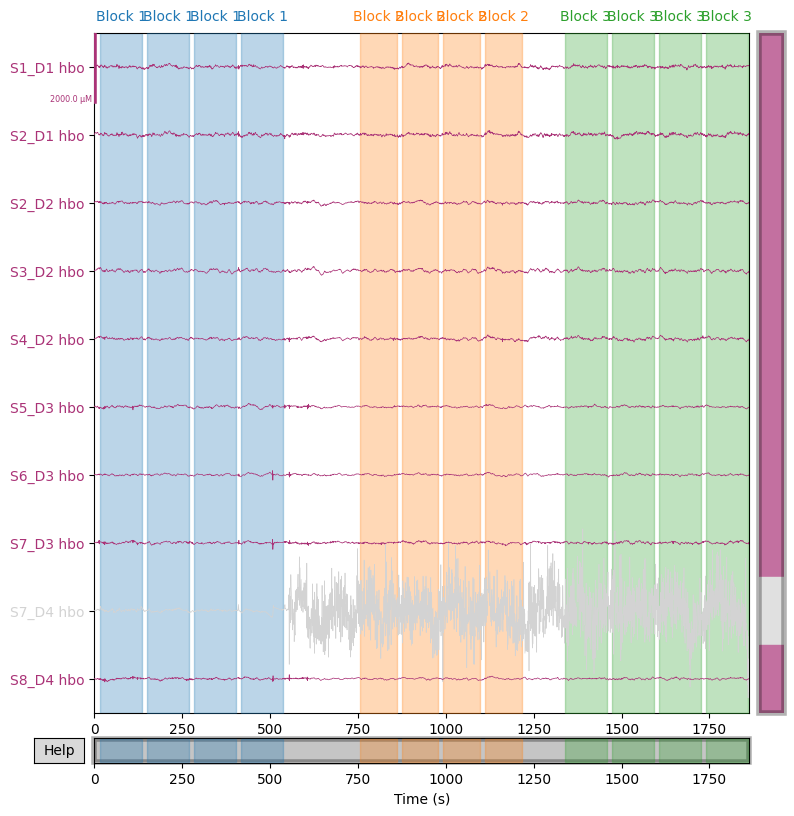

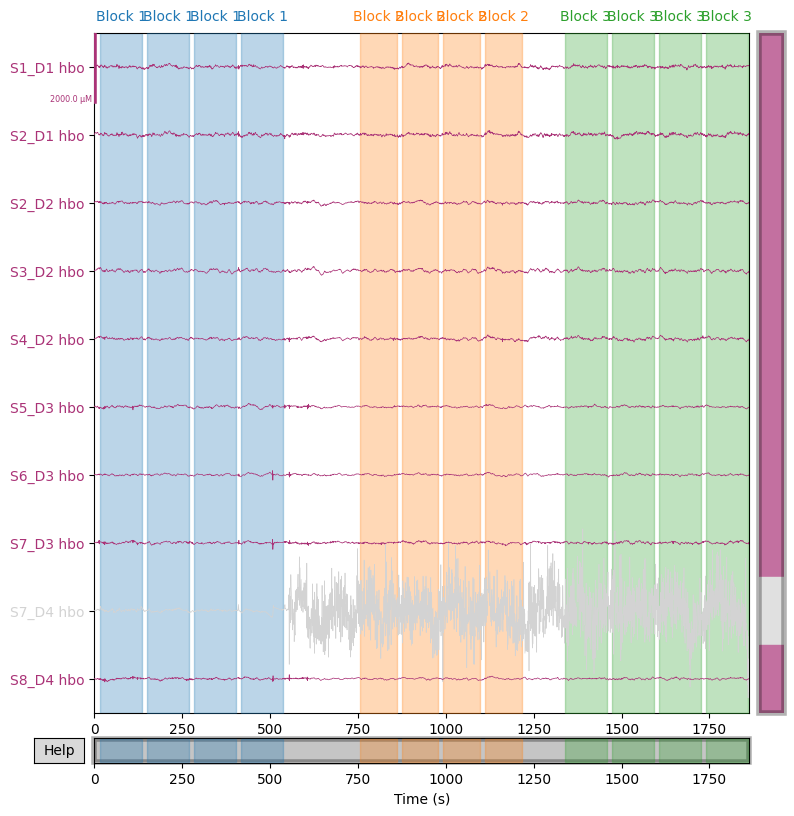

In [87]:
# example plot for 2200 seconds
#can either plot all hbo channels or a single channel for a subject
pps[51][0].copy().pick(['hbo']).plot(duration=2000, scalings=0.001)

In [88]:
sampling_rate = pps[0][0].info['sfreq']
print(sampling_rate)

7.8125


In [89]:
pps[10][0]

<RawNIRX | 1143-C_fNIRS_DB-DOS, 20 x 14845 (1900.2 s), ~2.3 MiB, data loaded>

In [90]:
# make a dictionary where all of the epoch'd data will go
epoch_df = {}

# loop over the dyads in the preprocessed list
for dscan in pps:
    
    # February 9th 2023
    # Clayton update to prune subjects who have
    # >= 10 channels dropped from the SCI function during preprocessing
    max_bad = max([len(scan.info['bads']) for scan in dscan])
    # whichever number is higher ^, num. of channels dropped in
    # either parent or child
    
    if max_bad >= 10:
        for scan in dscan:
            sub_num = scan.info['subject_info']['his_id']
            print("Subject {} was dropped from further analysis.".format(sub_num))
        
        continue # skip this dyad
        # if max_bad is greater than or equal to 10
    
    # for each scan in the dyad
    for scan in dscan:
    
        # set their location in the epoch df to a dictionary
        epoch_df[scan.info['subject_info']['his_id']] = {}
    
#        for i, ROI in enumerate(ROIs.keys()):

        # loop over ROIs (channels here)
        for i, ROI in enumerate([ch for ch in scan.info['ch_names'] if "hbo" in ch]):
            
            epoch_df[scan.info['subject_info']['his_id']][ROI] = []
        
            # get their events and set block durations
            events, event_dict = mne.events_from_annotations(dscan[0], verbose=False)
            reject_criteria = dict(hbo=200e-6)
            tmin, puzzletmax, playtmax = -5, 105, 120
            
            # use the mne.Epochs function / object to generate epochs
            preplay_epochs = mne.Epochs(
                scan, # the scan object
                events, # its events
#                 picks=ROIs[ROI],
                picks=[ROI], # the channels
                event_id={list(event_dict.keys())[0]: list(event_dict.values())[0]}, # the first event key
                tmin=tmin, # epoch relative start time
                tmax=playtmax, # epoch relative end time
                baseline= (None, 0), # baseline window to subtract
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1, # linear detrend
                verbose=False, 
                preload=False, # don't actually load it yet (saves memory)
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(preplay_epochs)
            
            puzzle_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[1]: list(event_dict.values())[1]},
                tmin=tmin,
                tmax=puzzletmax,
                baseline= (None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(puzzle_epochs)
            
            postplay_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[2]: list(event_dict.values())[2]},
                tmin=tmin,
                tmax=playtmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(postplay_epochs)

Subject 1191c was dropped from further analysis.
Subject 1130c was dropped from further analysis.
Subject 1130p was dropped from further analysis.
Subject 1115c was dropped from further analysis.
Subject 1115p was dropped from further analysis.
Subject 1176c was dropped from further analysis.
Subject 1176p was dropped from further analysis.


In [91]:
# here is the way to access information in the epoch dictionary

In [92]:
#Will tell you how many dyads are retaining for final analyses 
len([sub for sub in epoch_df.keys() if "c" in sub])

105

In [93]:
# a single subject 
epoch_df['1250c']

{'S1_D1 hbo': [<Epochs | 4 events (good & bad), -4.992 – 120.064 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
   'Block 1': 4>,
  <Epochs | 4 events (good & bad), -4.992 – 104.96 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
   'Block 2': 4>,
  <Epochs | 4 events (good & bad), -4.992 – 120.064 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
   'Block 3': 4>],
 'S2_D1 hbo': [<Epochs | 4 events (good & bad), -4.992 – 120.064 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
   'Block 1': 4>,
  <Epochs | 4 events (good & bad), -4.992 – 104.96 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
   'Block 2': 4>,
  <Epochs | 4 events (good & bad), -4.992 – 120.064 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
   'Block 3': 4>],
 'S2_D2 hbo': [<Epochs | 4 events (good & bad), -4.992 – 120.064 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
   'Block 1': 4>,
  <Epochs | 4 events (good & bad), -4.992 – 104.96 s (baseline -4.992 – 0 s), ~11 KiB, data not load

In [94]:
# a specific channel from the subject
epoch_df['1250c']['S1_D1 hbo']

[<Epochs | 4 events (good & bad), -4.992 – 120.064 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
  'Block 1': 4>,
 <Epochs | 4 events (good & bad), -4.992 – 104.96 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
  'Block 2': 4>,
 <Epochs | 4 events (good & bad), -4.992 – 120.064 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
  'Block 3': 4>]

In [95]:
# a specific block at that subject / channel, in this case the first (0) is pre-play, second (1) is puzzle, and second (2) is post-play
#ask Susan about baseline 
epoch_df['1250c']['S1_D1 hbo'][2]

<Epochs | 4 events (good & bad), -4.992 – 120.064 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
 'Block 3': 4>

In [96]:
# a specific iteration (trial) of that block at that subject / channel, in this case the first (0) is pre-play, we look at the 4th (3) iteration of the block
#120 sec duration of individual trial/iteration
epoch_df['1250c']['S1_D1 hbo'][0][3]

<Epochs | 1 events (good & bad), -4.992 – 120.064 s (baseline -4.992 – 0 s), ~11 KiB, data not loaded,
 'Block 1': 1>

In [97]:
event_dict

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}

Using data from preloaded Raw for 1 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 860 original time points ...
0 bad epochs dropped


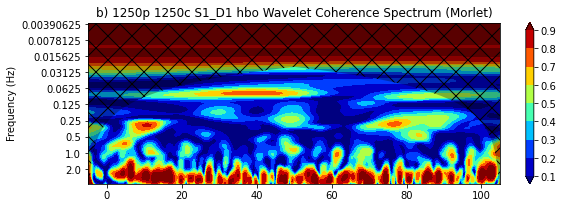

Using data from preloaded Raw for 1 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 860 original time points ...
0 bad epochs dropped


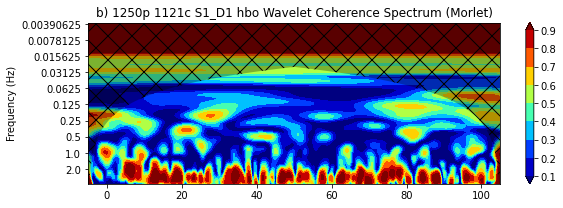

In [98]:
# example WCT between a real dyad, puzzle block (1), iteration 0 (0)
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['1250p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['1250c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

# same WCT but a random false dyad
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['1250p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['1121c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

In [99]:
# list out all the subjects in the epoch df
epoch_df.keys()

dict_keys(['1234c', '1234p', '1133c', '1133p', '1151c', '1151p', '1162c', '1162p', '1159c', '1159p', '1145c', '1145p', '1190c', '1190p', '1216c', '1216p', '1184c', '1184p', '1143c', '1143p', '1220c', '1220p', '1214c', '1214p', '1165c', '1165p', '1229c', '1229p', '1138c', '1138p', '1235c', '1235p', '1251c', '1251p', '1225c', '1225p', '1125c', '1125p', '1182c', '1182p', '1223c', '1223p', '1127c', '1127p', '1124c', '1124p', '1245c', '1245p', '1247c', '1247p', '1155c', '1155p', '1263c', '1263p', '1180c', '1180p', '1252c', '1252p', '1268c', '1268p', '1156c', '1156p', '1207c', '1207p', '1228c', '1228p', '1193c', '1193p', '1211c', '1211p', '1236c', '1236p', '1174c', '1174p', '1219c', '1219p', '1179c', '1179p', '1204c', '1204p', '1134c', '1134p', '1242c', '1242p', '1195c', '1195p', '1113c', '1113p', '1269c', '1269p', '1226c', '1226p', '1267c', '1267p', '1213c', '1213p', '1258c', '1258p', '1122c', '1122p', '1170c', '1170p', '1149c', '1149p', '1129c', '1129p', '1139c', '1139p', '1253c', '1253p',

In [100]:
# delete things we don't need anymore to save memory
del scans
del pps

In [101]:
import random

In [ ]:
# make a new dictionary where the synchrony values will be stored
sync_df = {}
block_types = ['Block 1', 'Block 2', 'Block 3']
block_names = ['Pre-Play', 'Puzzle', 'Post-Puzzle']
trials = ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4']
perm_df = {}

# THIS TAKES A REALLY LONG TIME TO COMPUTE. AROUND 14 HOURS ON A DECENT NETWORK
# SKIP DOWN TO USE THE SAVED VERSIONS!

#real vs single false dyad test of a myriad of real and fake dyad pairs

# for every parent subject
for parent in tqdm([sub for sub in sorted(epoch_df.keys()) if "p" in sub]):
    sync_df[parent] = {}
    perm_df[parent] = []
    
    # pick two children, one real and one random
    children = []
    
#     children.append(parent.replace("p", "c")) # real child
    
    # random sample of N children
    # could be repeated, could be the real dyad 
    randoms = random.choices(
        [sub for sub in epoch_df.keys() if "c" in sub],
        k=999) # N of random 
    # randoms = list(randoms).insert(0, parent.replace("p", "c"))
    perm_df[parent] = list(randoms)
    
    # only going to do synchrony once per kid
    # we can count # of repeats from perm_df[parent]
    for child in list(set(randoms)):
        children.append(child)
    
    # old version that just does 1 random non-real child per parent
#     children.append(
#         random.choice([sub for sub in epoch_df.keys() if "c" in sub \
#             and parent.replace("p", "") not in sub])) # random pick
    
    # loop over these 2 selected children (1 real, N random)
    for child in children:
        
        # and make them a location in the sync dictionary under this parent
        sync_df[parent][child] = {}
        
        # for every block type (pre-play, puzzle, post-play)
        for block_num, block in enumerate(block_types):
            
            # make this parent/child combo a location for this block type, also a dictionary
            sync_df[parent][child][block] = {}
                
            # for each channel available with this subject (not dropped)
            for ch in epoch_df[parent].keys():

                # our sync value is going to go here
                # sync_df[parent][child][block][ch]
                # i.e. averaging over the 4 block iterations

                # so start keeping track of values to average now
                pc_wcts = []

                # load in their epoched data for this subject / channel / block
                p_epoch = epoch_df[parent][ch][block_num].load_data()
                c_epoch = epoch_df[child][ch][block_num].load_data()

                # for each iteration of this block (max 4)
                for block_it in np.arange(0, np.min([
                    len(p_epoch),
                    len(c_epoch)])):

                    # try to do the WCT with these epochs
                    try:
                        sync_df[parent][child][block][f'Trial {block_it + 1}'] = {}
                        WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
                            p_epoch[block_it],
                            c_epoch[block_it],
                            plot=True if "S5_D3" in ch else False, # save plots but only for some random channel because otherwise it's an insane amount
                            fig_fname=f"/data/perlman/moochie/analysis/eDOC_NARSAD/sync_figs/{parent}_{child}_{ch.replace(' ', '_')}_{block_num}_{block_it}.png")

                        # make values outside COI = np.nan
                        nanWCT = WCT
                        for t in range(nanWCT.shape[1]):
                            nanWCT[np.where(freqs>coi[t]), t] = np.nan
                        # also set to nan outside frequencies of interest

                        # TASK RELATED FREQUENCIES ARE ARBITRARILY DETERMINED here
                        WCT[(2>(1/freqs))|((1/freqs)>13), :] = np.nan

                        # between periods of 2s and 13s (.08 -.5 Hz; flip for sec) which is based on Reindl et al 2018 paper (in Reindl study a single trial typcially took 5-8 sec)
                        #also in Reindl paper, significant coherence values were identifed above .65 (can be between 0 and 1)


                        # average inside cone of influence
                        # and within values from freq range determined above
                        sync_df[parent][child][block][f'Trial {block_it + 1}'][ch] = np.nanmean(nanWCT)
                    # if anything with the WCT fails, say so
                    except:
                        print(f"Fail @ parent {parent}, child {child}, block {block}, channel {ch}, block it {block_it}")
#                 print(np.average(pc_wcts))  


                

  0%|          | 0/105 [00:00<?, ?it/s]

Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

  1%|          | 1/105 [29:31<51:10:24, 1771.39s/it]

Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Fail @ parent 1113p, child 1133c, block Block 1, channel S5_D3 hbo, block it 0
Fail @ parent 1113p, child 1133c, block Block 1, channel S5_D3 hbo, block it 1
Fail @ parent 1113p, child 1133c, block Block 1, channel S5_D3 hbo, block it 2
Fail @ parent 1113p, child 1133c, block Block 1, channel S5_D3 hbo, block it 3
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using

  2%|▏         | 2/105 [57:28<49:06:01, 1716.13s/it]

Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Fail @ parent 1114p, child 1133c, block Block 1, channel S5_D3 hbo, block it 0
Fail @ parent 1114p, child 1133c, block Block 1, channel S5_D3 hbo, block it 1
Fail @ parent 1114p, child 1133c, block Block 1, channel S5_D3 hbo, block it 2
Fail @ parent 1114p, child 1133c, block Block 1, channel S5_D3 hbo, block it 3
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using

  3%|▎         | 3/105 [1:34:46<55:22:35, 1954.47s/it]

Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Fail @ parent 1116p, child 1133c, block Block 1, channel S5_D3 hbo, block it 0
Fail @ parent 1116p, child 1133c, block Block 1, channel S5_D3 hbo, block it 1
Fail @ parent 1116p, child 1133c, block Block 1, channel S5_D3 hbo, block it 2
Fail @ parent 1116p, child 1133c, block Block 1, channel S5_D3 hbo, block it 3
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using

  4%|▍         | 4/105 [2:04:35<52:59:53, 1889.05s/it]

Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Fail @ parent 1117p, child 1133c, block Block 1, channel S5_D3 hbo, block it 0
Fail @ parent 1117p, child 1133c, block Block 1, channel S5_D3 hbo, block it 1
Fail @ parent 1117p, child 1133c, block Block 1, channel S5_D3 hbo, block it 2
Fail @ parent 1117p, child 1133c, block Block 1, channel S5_D3 hbo, block it 3
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using

  5%|▍         | 5/105 [2:36:49<52:55:03, 1905.04s/it]

Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Fail @ parent 1121p, child 1133c, block Block 1, channel S5_D3 hbo, block it 0
Fail @ parent 1121p, child 1133c, block Block 1, channel S5_D3 hbo, block it 1
Fail @ parent 1121p, child 1133c, block Block 1, channel S5_D3 hbo, block it 2
Fail @ parent 1121p, child 1133c, block Block 1, channel S5_D3 hbo, block it 3
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using

  6%|▌         | 6/105 [3:07:28<51:46:40, 1882.83s/it]

Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Fail @ parent 1122p, child 1133c, block Block 1, channel S5_D3 hbo, block it 0
Fail @ parent 1122p, child 1133c, block Block 1, channel S5_D3 hbo, block it 1
Fail @ parent 1122p, child 1133c, block Block 1, channel S5_D3 hbo, block it 2
Fail @ parent 1122p, child 1133c, block Block 1, channel S5_D3 hbo, block it 3
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using

  7%|▋         | 7/105 [3:38:42<51:10:19, 1879.79s/it]

Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Fail @ parent 1124p, child 1133c, block Block 1, channel S5_D3 hbo, block it 0
Fail @ parent 1124p, child 1133c, block Block 1, channel S5_D3 hbo, block it 1
Fail @ parent 1124p, child 1133c, block Block 1, channel S5_D3 hbo, block it 2
Fail @ parent 1124p, child 1133c, block Block 1, channel S5_D3 hbo, block it 3
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using

  8%|▊         | 8/105 [4:09:16<50:15:37, 1865.34s/it]

Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Fail @ parent 1125p, child 1133c, block Block 1, channel S5_D3 hbo, block it 0
Fail @ parent 1125p, child 1133c, block Block 1, channel S5_D3 hbo, block it 1
Fail @ parent 1125p, child 1133c, block Block 1, channel S5_D3 hbo, block it 2
Fail @ parent 1125p, child 1133c, block Block 1, channel S5_D3 hbo, block it 3
Using data from preloaded Raw for 4 events and 978 original time points ...
0 bad epochs dropped
Using

In [ ]:
sync_df['1110p']['1160c']['Block 2']['Trial 1'].keys()

In [ ]:
list(sync_df['1194p']['1194c']['Block 1']['Trial 1'].values())

In [ ]:
#important to set channels here
channels = epoch_df[].keys()

In [ ]:
channels

In [ ]:
epoch_df['1176p']

In [ ]:
# ATTENTION READ THE FOLLOWING COMMENT CAREFULLY BEFORE PROCEEDING (Stats test are being ran concerning study hypotheses, use a different notebook)

In [ ]:
# skip if you're going to load the already-saved ones. for real. don't overwrite this with an empty data file. 
# SAVE SYNCHRONY VALUES

import json
json_object = json.dumps(sync_df, indent=4)

with open("/data/perlman/moochie/analysis/P-CAT/Test_Analysis/trail_wct_full_permuted_values.json", 'w') as outfile:
    json.dump(sync_df, outfile)
    
    
# also save as CSV
import pandas as pd

cols = ["Parent", "Child", "Block", "Trial"]
for ch in channels:
    cols.append(ch)
    
df = pd.DataFrame(columns=cols)    

for parent in sync_df.keys():
    
    for child in sync_df[parent].keys():
        
        for block in sync_df[parent][child].keys():
            
            for trial in sync_df[parent][child][block].keys():
            
                dic = {
                    'Parent': parent,
                    'Child': child,
                    'Block': block,
                    'Trial': trial}

                for key, val in sync_df[parent][child][block][trial].items():
                    dic[key] = val

    #             print(dic)
                df = df.append(dic, ignore_index=True)
        
print(df)
df.to_csv("/data/perlman/moochie/analysis/P-CAT/Test_Analysis/trial_wct_full_permuted_values_fixed.csv")

In [ ]:
# Save permuted values

json_object = json.dumps(perm_df, indent=4)
with open("/data/perlman/moochie/analysis/CARE/Test_Analysis/trial_permuted_subjects_fixed.json", 'w') as outfile:
    json.dump(perm_df, outfile)

In [ ]:
# LOAD PERMUTED SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/P-CAT/PSU_Joscelin_Permutation_Output/trial_permuted_subjects.json", 'r') as infile:
    perm_df = json.load(infile)

In [ ]:
# LOAD REAL SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/P-CAT/PSU_Joscelin_Permutation_Output/trial_wct_permuted_values_fixed.json", 'r') as infile:
    sync_df = json.load(infile)

In [ ]:
# how many parents are in there (some may be repeated because they have multiple children in the study)
len(sync_df.keys())

In [ ]:
sync_df.keys()

In [ ]:
# how many parents are in there, without repeats
len(set([sub[:-2] for sub in list(sync_df.keys())]))

In [ ]:
#THE BEGINNING OF REAL VS FALSE DYADS STATS

In [ ]:
pruned_sync_df = copy(sync_df)

In [ ]:
#BAD CHANNEL PRUNING
for parent in pruned_sync_df.keys():
    
    for child in pruned_sync_df[parent].keys():
        
        for block in pruned_sync_df[parent][child].keys():
            
            for channel in pruned_sync_df[parent][child][block].keys():
                
                
                if (parent in bad_channels_dict.keys() and channel in bad_channels_dict[parent]):
                    pruned_sync_df[parent][child][block][channel] = np.nan
                    
                if (child in bad_channels_dict.keys() and channel in bad_channels_dict[child]):
                    pruned_sync_df[parent][child][block][channel] = np.nan

In [ ]:
np.isnan(pruned_sync_df['1250p']['1250c']['Block 1']['S1_D1 hbo'])

In [ ]:
#1) AVERAGE ACROSS All ROIs

In [ ]:
#to check whether all real dyads are included in the permuted excel file
for parent in sync_df.keys(): 
    if not (parent.replace("p", "c") in sync_df[parent].keys()):
        print(parent)

In [ ]:
dyad_b1 = [] # make a base list for real dyads
nyad_b1 = [] # make a base list for false dyads

# this is just using Block 1 = Pre-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 1'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b1.append(
                sync_df[parent][real_child]['Block 1'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 1'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b1.append(
                    sync_df[parent][false_child]['Block 1'][ch])
                
    #REMOVE NaN values from REAL dyad list
    dyad_list1 = []
    dyad_list2 = []
    dyad_b1_new = [] #this will be new real dyad variable 

    for x in dyad_b1:
        x = str(x)
        dyad_list1 += [x]

    for x in dyad_list1:
        if x == 'nan':
            del x
        else:
            dyad_list2 += [x]

    for x in dyad_list2:
        x = float(x)
        dyad_b1_new += [x]
        
    #REMOVE NaN values from FALSE dyad list
    nyad_list1 = []
    nyad_list2 = []
    nyad_b1_new = [] #this will be the new false dyad variable

    for x in nyad_b1:
        x = str(x)
        nyad_list1 += [x]

    for x in nyad_list1:
        if x == 'nan':
            del x
        else:
            nyad_list2 += [x]

    for x in nyad_list2:
        x = float(x)
        nyad_b1_new += [x]

In [ ]:
dyad_b2 = [] # make a list for real dyads
nyad_b2 = [] # make a list for not-real dyads

# this is just using Block 2 = Puzzle

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 2'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b2.append(
                sync_df[parent][real_child]['Block 2'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 2'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b2.append(
                    sync_df[parent][false_child]['Block 2'][ch])
                
    #REMOVE NaN values from REAL dyad list
    dyad_list1 = []
    dyad_list2 = []
    dyad_b2_new = [] #this will be new real dyad variable 

    for x in dyad_b2:
        x = str(x)
        dyad_list1 += [x]

    for x in dyad_list1:
        if x == 'nan':
            del x
        else:
            dyad_list2 += [x]

    for x in dyad_list2:
        x = float(x)
        dyad_b2_new += [x]
        
    #REMOVE NaN values from FALSE dyad list
    nyad_list1 = []
    nyad_list2 = []
    nyad_b2_new = [] #this will be the new false dyad variable

    for x in nyad_b2:
        x = str(x)
        nyad_list1 += [x]

    for x in nyad_list1:
        if x == 'nan':
            del x
        else:
            nyad_list2 += [x]

    for x in nyad_list2:
        x = float(x)
        nyad_b2_new += [x]

In [ ]:
dyad_b3 = [] # make a list for real dyads
nyad_b3 = [] # make a list for not-real dyads

# this is just using Block 3 = Post-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 3'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b3.append(
                sync_df[parent][real_child]['Block 3'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 3'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b3.append(
                    sync_df[parent][false_child]['Block 3'][ch])
                
    #REMOVE NaN values from REAL dyad list
    dyad_list1 = []
    dyad_list2 = []
    dyad_b3_new = [] #this will be new real dyad variable 

    for x in dyad_b3:
        x = str(x)
        dyad_list1 += [x]

    for x in dyad_list1:
        if x == 'nan':
            del x
        else:
            dyad_list2 += [x]

    for x in dyad_list2:
        x = float(x)
        dyad_b3_new += [x]
        
    #REMOVE NaN values from FALSE dyad list
    nyad_list1 = []
    nyad_list2 = []
    nyad_b3_new = [] #this will be the new false dyad variable

    for x in nyad_b3:
        x = str(x)
        nyad_list1 += [x]

    for x in nyad_list1:
        if x == 'nan':
            del x
        else:
            nyad_list2 += [x]

    for x in nyad_list2:
        x = float(x)
        nyad_b3_new += [x]

In [ ]:
plt.clf()
plt.violinplot(
    [dyad_b1_new, nyad_b1_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#synchrony values of real and non-real dyads plotted
plt.boxplot(
    [dyad_b1_new, nyad_b1_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
plt.clf()
plt.violinplot(
    [dyad_b2_new, nyad_b2_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#synchrony values of real and non-real dyads plotted
plt.boxplot(
    [dyad_b2_new, nyad_b2_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
plt.clf()
plt.violinplot(
    [dyad_b3_new, nyad_b3_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#synchrony values of real and non-real dyads plotted
plt.boxplot(
    [dyad_b3_new, nyad_b3_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#TWO SAMPLE T-TESTS ARE RAN HERE

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
#Pre-Play
statistic, pvalue = ttest_ind(
    dyad_b1_new,
    nyad_b1_new)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#Puzzle
statistic, pvalue = ttest_ind(
    dyad_b2_new,
    nyad_b2_new)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#Post-Play
statistic, pvalue = ttest_ind(
    dyad_b3_new,
    nyad_b3_new)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#REAL vs BASELINE (zeroes)/One-Sample T-Tests 

In [ ]:
#find length of block variable first for each real or false synchrony scores
len(dyad_b2_new)

In [ ]:
#Set a list of zeroes for one-sample t-test comparisons
zyad_z1 = []

for num in range(952):
    zyad_z1.append(0)

In [ ]:
#One-Sample T-tests 
statistic, pvalue = ttest_ind(
    dyad_b2_new,
    zyad_z1)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#TESTING BETWEEN BLOCK DIFFERECNES BETWEEN REAL DYADS (AVERAGE ACROSS ALL BLOCKS) THERE SHOULD BE 3 COMBINATIONS TOTAL

In [ ]:
#Block by Block Conparisons, Real Dyads ONLY!
statistic, pvalue = ttest_ind(
    dyad_b2_new,
    dyad_b1_new)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#2) HERE CAN TEST SPECIFIC ROIs (CHANNELS) BETWEEN REAL vs FALSE DYADS

In [ ]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
  'S3_D2 hbo', # left frontal
  'S4_D2 hbo',
  'S5_D3 hbo', # right frontal
  'S6_D3 hbo',
#    'S1_D1 hbo', # left temporal
#    'S2_D1 hbo',
#    'S2_D2 hbo',
#    'S7_D3 hbo', #right temporal
#    'S7_D4 hbo',
#    'S8_D4 hbo'
]

dyad_c1 = [] # make a list for real dyads
nyad_c1 = [] # make a list for not-real dyads

# this is just using Block 1 = Pre-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c1.append(
                sync_df[parent][real_child]['Block 1'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c1.append(
                    sync_df[parent][false_child]['Block 1'][ch])

In [ ]:
#Pre-Play T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_c1,
    nyad_c1)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
    'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
#      'S5_D3 hbo', # right frontal
#      'S6_D3 hbo',
     'S1_D1 hbo', # left temporal
     'S2_D1 hbo',
     'S2_D2 hbo',
#      'S7_D3 hbo', #right temporal
#      'S7_D4 hbo',
#      'S8_D4 hbo'
]

dyad_c2 = [] # make a list for real dyads
nyad_c2 = [] # make a list for not-real dyads

# this is just using Block 2 = Puzzle

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c2.append(
                sync_df[parent][real_child]['Block 2'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c2.append(
                    sync_df[parent][false_child]['Block 2'][ch])

In [ ]:
#Puzzle T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_b2,
    nyad_c2)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
      'S3_D2 hbo', # left frontal
      'S4_D2 hbo',
#       'S5_D3 hbo', # right frontal
#       'S6_D3 hbo',
      'S1_D1 hbo', # left temporal
      'S2_D1 hbo',
      'S2_D2 hbo',
#       'S7_D3 hbo', #right temporal
#       'S7_D4 hbo',
#       'S8_D4 hbo'
]

dyad_c3 = [] # make a list for real dyads
nyad_c3 = [] # make a list for not-real dyads

# this is just using Block 3 = Post-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c3.append(
                sync_df[parent][real_child]['Block 3'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c3.append(
                    sync_df[parent][false_child]['Block 3'][ch])

In [ ]:
#Post-Play T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_c3,
    nyad_c3)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#INCORPORATION of FACES QUESTIONNAIRE SCORES BEGINS HERE (other PCAT Measures will be included here)

In [ ]:
#The code and CSV for the OLD RDAS files for reference (DON'T RUN THIS SECTION)

In [ ]:
# load CSV from emily Hone groups
# groups = pd.read_csv("/data/perlman/moochie/analysis/CARE/forperlman_rdaslist_20221101.csv")
# groups['subject'] = [id.replace('-', '') for id in groups['record_id']]
# groups.set_index('subject', inplace=True)

In [ ]:
groups

In [ ]:
# load CSV from emily Hone's RDAS scores
# scores = pd.read_csv("/data/perlman/moochie/analysis/CARE/forkhalil_fullscored.csv")
# scores['subject'] = [id.replace('-', '') for id in scores['record_id']]
# scores.set_index('subject', inplace=True)
# scores.drop(columns=['record_id'], inplace=True)
# scores = scores.astype({'famid': 'str'})

In [ ]:
# scores

In [ ]:
# see how many rows there are in there
# weird number, huh?
# it's because not everybody has RDAS data :(
# len([id for id in scores.index])

In [ ]:
#START HERE (INCORPORATE ANY RECENT PCAT QUESTIONNAIRE DATA HERE)

In [ ]:
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
      'Cohesion_Raw_Score',
      'Flexibility_Raw_Score',
      'Disengaged_Raw_Score',
      'Enmeshed_Raw_Score',
      'Rigid_Raw_Score',
      'Chaotic_Raw_Score',
#     'total'
]

channels = [
     'S3_D2 hbo', # left frontal
     'S4_D2 hbo',
     'S5_D3 hbo', # right frontal
     'S6_D3 hbo',
     'S1_D1 hbo', # left temporal
     'S2_D1 hbo',
     'S2_D2 hbo',
     'S7_D3 hbo', # right temporal
     'S7_D4 hbo',
     'S8_D4 hbo',
]

In [ ]:
channels

In [ ]:
COIs

In [ ]:
# load CARE Pitt Group CSV 
scores = pd.read_csv("/data/perlman/moochie/analysis/P-CAT/faces_scores.csv")
scores['subject'] = [id for id in scores['Subject_ID']]
scores = scores.astype({'subject': 'str'})
scores = scores.mask(scores == ' ')
for COI in COIs:
    scores = scores.astype({COI: 'float'})
scores.set_index('subject', inplace=True)
scores.drop(columns=['Subject_ID'], inplace=True)

In [ ]:
#FACES = Familiy Adaptability and Cohesion Scale
scores

In [ ]:
scores.columns

In [ ]:
scores.index

In [ ]:
# see how many rows there are in there
len([id for id in scores.index])

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [ ]:
# this is because, in the sync_df, we need to have a way to differentiate between the parent and child. so subject names are, e.g.
# 1234p or 1234c. Whereas, in your .csv / dataframe for other variables of interest, they are not specific to a parent or child, but a family. 
# so we often combine these values by looping over the parents (top level values in sync_df that end in "p"), and then reference that name,
# with the "p" replaced by "" (nothing) to access the correct value in the dataframe. 

channels = [
#       'S3_D2 hbo', # left frontal
#       'S4_D2 hbo',
#      'S5_D3 hbo', # right frontal
#      'S6_D3 hbo',
     'S1_D1 hbo', # left temporal
     'S2_D1 hbo',
     'S2_D2 hbo',
     'S7_D3 hbo', # right temporal
     'S7_D4 hbo',
     'S8_D4 hbo'
]

#Set the Block of Interest here

block_num = 'Block 1'
block_name = 'Pre-Play (Temporal)'

# Set an identifier function for handling family id
# Use the difference in size of the ID's as a guide
sync_sample = list(sync_df.keys())[0]
scores_sample = scores.index[0]
identifier_diff =  len(scores_sample) - len(sync_sample) # Figure out how much smaller the scores sample is
score_identifier = lambda string : string[:identifier_diff]

# Variant 1 (individual block)
# ==================
# for all the parent / child pairs who are listed in the scores .csv / dataframe,
#    and averaging over all the channels that are uncommented above
#    so this will yield a list called "syncs" which is as long as the number of parent / child pairs 
#    that are found in both sync_df and the scores dataframe
#    i.e. 1 averaged WTC value per dyad, specifically derived from whichever block is named in 
#    "block_num" above.

syncs = []
sync_parents = []
for parent in list(sync_df.keys()):
    dyad_syncs = []
    child = parent.replace('p', 'c')
    if score_identifier(parent) in list(scores.index):
        for ch in channels:
            if ch not in bad_channels_dict[parent]:
                if ch not in bad_channels_dict[child]:
                    dyad_syncs.append(sync_df[parent][child][block_num][ch])
    if len(dyad_syncs) > 0:
        syncs.append(np.average(dyad_syncs))
        sync_parents.append(parent)
        
print(sync_parents)


# Variant 2 (block difference)
# ==================
# this version is doing the same thing, but specifically looking at the _difference_ of the WTC
#    in a dyad between two blocks. In this example, you can see that it is marking the difference
#    between sync of 'Block 2' and 'Block 1'. You are welcome to configure those variables 
#    as you see fit. The shape of the output list, syncs, will be the same as in Variant 1, and you
#    could use it just as well in any subsequent regressions, etc.  


# syncs = []
# sync_parents = []
# for parent in list(sync_df.keys()):
#    dyad_syncs = []
#    child = parent.replace('p', 'c')
#    if parent.replace('p', '') in list(scores.index):
#       for ch in channels:
#          if ch not in bad_channels_dict[parent]:
#             if ch not in bad_channels_dict[child]:
#                dyad_syncs.append(
#                   sync_df[parent][child]['Block 2'][ch] - \
#                   sync_df[parent][child]['Block 1'][ch])
#    if len(dyad_syncs) > 0:
#       syncs.append(np.average(dyad_syncs))
#       sync_parents.append(parent)


# Regression
# ================
# looping over the "columns of interest" which should be defined in a previous cell. as COIs = [ <stuff> ]
#     i.e., the names of any columns in your .csv you want to run regression on
for COI in COIs:

    # get the current variable of interest from the "scores" dataframe
    #    once again, only for subjects who are found in both the sync_df 
    #    and in the scores dataframe / .csv.
    voi = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_parents]]
    
    # force the values read to be interpreted as float, as opposed to default string
    xnan = np.array(voi, dtype='float')
    ynan = np.array(syncs, dtype='float')

    # IQR correction if desired
#         # get IQR
#         q75, q25 = np.percentile(xnan, [75, 25])
#         intr_qr = q75 - q25
#         qmax = q75 + (1.5 * intr_qr)
#         qmin = q25 - (1.5 * intr_qr)
#         # remove the extra-IQR vals
#         xnan[xnan < qmin] = qmin
#         xnan[xnan > qmax] = qmin

    # remove any values that are NaN (hopefully none?) otherwise there
    #    may be issues in your .csv format 

    
    x = np.delete(xnan, np.where(np.isnan(xnan)))
    y = np.delete(ynan, np.where(np.isnan(xnan)))
    
    x = np.delete(x, np.where(np.isnan(y)))
    y = np.delete(y, np.where(np.isnan(y)))

    # Winsorize function (not recommended)
    # winsorize(y, inplace=True, limits=[0.05, 0.05])
    # winsorize(x, inplace=True, limits=[0.05, 0.05])

    # duplicate variables for use in regression (requires reshaping)
    X = x
    Y = y
    x = x.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    print(f"Coefficient of Determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    print(f"slope: {model.coef_}")

    # plot data
    plt.clf()
    plt.scatter(
        x,
        y,
        color='black')

    # plot regression line
    plt.plot(
        np.linspace(np.min(x), np.max(x)),
        model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
        color='blue',
        linewidth=1.5)

    plt.xlabel(f" {COI.upper()}")
    plt.ylabel(f"Dyadic Synchrony in {block_name}")
    plt.title(f"{block_name}: {COI}")
    plt.show()
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    print(est2.summary())

In [ ]:
#Older code to run group analysis for RDAS data (CAN STOP HERE UNLESS YOU NEED TO RUN GROUPS)

In [ ]:
# Differences in synchrony between the conflict and non-conflict group
group1syncs = [] # get synchrony from all of groups 1 (control)
group2syncs = [] # get synchrony from problem group

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

for sub in sync_df.keys():
    avgsync = np.average([
        sync_df[sub][sub.replace('p', 'c')]['Block 2'][ch] for ch in channels])
    
    if (groups.loc[[sub.replace('p', '')]]['enroll_group'][0] == "Control") and \
        (groups.loc[[sub.replace('p', '')]]['rdas_group'][0] == "Non-Conflict"):
        group1syncs.append(avgsync)
    else:
        group2syncs.append(avgsync)
        
plt.clf()
plt.violinplot(
    [group1syncs, group2syncs],
    showmeans=True)
plt.show()

statistic, pvalue = ttest_ind(
    group1syncs,
    group2syncs)

print("T stat:", statistic, "\n", "P value:", pvalue)

In [ ]:
np.std(group2syncs)

In [ ]:
# enrollment group 2 OR above RDAS critical value == conflict group

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [ ]:
#configuration section that allows you to change which blocks, RDAS columns, and channels you want to include in subsequent analysis
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
    'consensus',
    'satisfaction',
    'cohesion',
#     'total'
]

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]